In [70]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib.ticker as mtick

import statsmodels
import scipy

import datetime as dt
import quantecon as qe


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

## Table des matières


[1. Nettoyage](#nettoyage)

[2. Analyse descriptive](#analyse)

[3. Chiffre d'affaires](#ca)
 
[4. Mise en évidence des corrélations](#correlations)

[5. Test du khi-deux entre deux variables qualitatives](#chi2)

[Annexes](#annexes)

* [Dispersion du CA et panier moyen par sexe](#gender)
* [Annexe : matrice de corrélation sexe / catégorie de produit](#gender_cat)
* [Potentiels revendeurs](#resellers)
* [Zoom sur le top des clients rapportant 80% du CA](#zoom_80%)
* [Calcul manuel du khi-deux entre deux qualitatives : classe d'âge du client et catégorie du produit](#manual_chi2)

In [3]:
# définition d'une classe de couleurs pour formater le texte
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [4]:
# importation des données
customers = pd.read_csv('data/customers.csv')
products = pd.read_csv('data/products.csv')
transactions = pd.read_csv('data/transactions.csv')

# 1. Nettoyage <a class="anchor" id="nettoyage"></a>

Pour base, 3 fichiers liés aux transactions de nos clients sur le site de la librairie étaient fournis :

- **un fichier clients ("customers"), regroupant :**
    - les identifiants liés aux clients
    - leur sexe ainsi 
    - leur année de naissance
- **un fichier produits ("products") :**
    - l'identifiant du produit
    - le prix
    - la catégorie, qui ne comprend que 3 unités : 0, 1 et 2
- **un fichiers transactions :**
    - l'identifiant du produit
    - la date d'achat du produit en question
    - l'identifiant de la session, que nous rapprocherons ici du panier
    - l'identifiant du client
    
Il sera déterminant de bien vérifier que les identifiants clients et produits sont bien uniques dans les deux premiers fichiers, mais aussi qu'il n'y a pas de lignes dupliquées dans les transactions. Enfin, il faudra s'assurer qu'il n'y ait pas de valeurs manquantes.

## Aperçu des fichiers

### Customers

In [5]:
print(customers.head())

  client_id sex  birth
0    c_4410   f   1967
1    c_7839   f   1975
2    c_1699   f   1984
3    c_5961   f   1962
4    c_5320   m   1943


#### Vérification du nombre de valeurs nulles par colonnes

In [6]:
customers.isnull().sum()

client_id    0
sex          0
birth        0
dtype: int64

#### Vérifications des clés

In [7]:
print("Il y a " + color.BOLD + color.RED + f"{len(customers) - customers['client_id'].nunique()} id(s) dupliqué(s)" + color.END, 
      "dans le dataframe customers.")

Il y a 0 id(s) dupliqué(s) dans le dataframe customers.


### Products

In [8]:
print(products.head())

  id_prod  price  categ
0  0_1421  19.99      0
1  0_1368   5.13      0
2   0_731  17.99      0
3   1_587   4.99      1
4  0_1507   3.99      0


#### Vérification du nombre de valeurs nulles par colonnes

In [9]:
products.isnull().sum()

id_prod    0
price      0
categ      0
dtype: int64

#### Vérifications des clés

In [10]:
print("Il y a " + color.BOLD + color.RED + f"{len(products) - products['id_prod'].nunique()} id(s) dupliqué(s)" + color.END, 
      "dans le dataframe products.")

Il y a 0 id(s) dupliqué(s) dans le dataframe products.


### Transactions

In [11]:
print(transactions.head())

  id_prod                        date session_id client_id
0  0_1518  2022-05-20 13:21:29.043970   s_211425     c_103
1   1_251  2022-02-02 07:55:19.149409   s_158752    c_8534
2  0_1277  2022-06-18 15:44:33.155329   s_225667    c_6714
3   2_209  2021-06-24 04:19:29.835891    s_52962    c_6941
4  0_1509  2023-01-11 08:22:08.194479   s_325227    c_4232


#### Vérification du nombre de valeurs nulles par colonnes

In [12]:
products.isnull().sum()

id_prod    0
price      0
categ      0
dtype: int64

## 1.1 Retrait des clients, produits et transactions non pertinents<a class="anchor" id="customers"></a>

### 1.1.1 Les clients "test" et leurs transactions

- les identifiants 'ct_01' et 'ct_02' correspondent à des tests et sont donc retirés des données
- il en va de même pour le produit 'T_0' dans le jeu de données products, dont le prix était de -1
- enfin, les dates de ces tests seront elles aussi retirées des transactions  

In [13]:
# clients "test" repérés lors de l'exploration du df transactions
test_clients = customers.loc[customers['client_id'].isin(['ct_0', 'ct_1'])]

# retrait des produits tests identifiés de products
tests = products.loc[products['id_prod']=='T_0'].copy()
products = products.loc[products["id_prod"]!='T_0']

# retrait des transactions test
transactions = transactions.loc[transactions['id_prod']!='T_0']

In [14]:
# conservation d'un df customers original et retrait des clients tests identifiés de customers
customers_0 = customers
customers = customers.loc[customers['client_id'].isin(test_clients['client_id'].unique())==False]

### 1.1.2 Vérifications liées au nombre de transactions

groupby sur les transactions afin de déterminer **combien d'achats et de sessions** ont été réalisés par client, mais aussi par produit

- retrait des <font color = 'red'>**clients sans transactions**</font> observées 
- retrait des <font color = 'red'>**produits sans transactions**</font> observées
- ajout dans le dataframe d'<font color = 'red'>**un produit manquant**</font> observé dans les transactions
    - après observation de la moyenne des prix ([Graphique associé](#bp_prices)), j'ai opté pour lui attribuer la moyenne de sa catégorie
    - ajout de la catégorie 0 au produit en raison du format de son id : '0_2245'
- identification de <font color = 'red'>**4 clients au nombre de sessions atypiques**</font> et isolement
    - création d'un dataframe de tarnsactions dédié pour founrir un aperçu de leurs activités en annexes, mais aussi pour mesurer leur poids dans le chiffre d'affaires


#### Retrait des clients sans achats

In [15]:
# groupby pour obtenir le nombre de produits achetés et le nombre de sessions
clients_trans = transactions.groupby('client_id')['id_prod'].count().reset_index()
clients_sessions = transactions.groupby('client_id')['session_id'].nunique().reset_index()

# merge des deux pivots précédents avec le df customers
customers = pd.merge(customers, clients_sessions, on='client_id', how='left')
customers = pd.merge(customers, clients_trans, on='client_id', how='left')

# renommer les colonnes
customers = customers.rename(columns={'session_id':'sessions_count', 
                                      'id_prod': 'trans_count'})

# création d'une liste de cllients sans transactions
customers_without = customers.loc[customers['trans_count'].isnull()]

print(color.BOLD + color.RED +  f"{len(customers_without)} Clients sans achats:\n\n" + color.END,customers_without)
# mise à jour de la liste des clients pour ne garder que ceux qui ont des transactions
customers = customers.loc[customers['trans_count'].isnull()==False]

21 Clients sans achats:

      client_id sex  birth  sessions_count  trans_count
801     c_8253   f   2001             NaN          NaN
2483    c_3789   f   1997             NaN          NaN
2734    c_4406   f   1998             NaN          NaN
2768    c_2706   f   1967             NaN          NaN
2850    c_3443   m   1959             NaN          NaN
3178    c_4447   m   1956             NaN          NaN
3189    c_3017   f   1992             NaN          NaN
3333    c_4086   f   1992             NaN          NaN
3720    c_6930   m   2004             NaN          NaN
3820    c_4358   m   1999             NaN          NaN
4723    c_8381   f   1965             NaN          NaN
4790    c_1223   m   1963             NaN          NaN
6111    c_6862   f   2002             NaN          NaN
6207    c_5245   f   2004             NaN          NaN
6337    c_5223   m   2003             NaN          NaN
6470    c_6735   m   2004             NaN          NaN
6584     c_862   f   1956             N

#### Retrait des produits non-vendus

In [16]:
list_products = products['id_prod'].unique()
list_sold = transactions['id_prod'].unique()
list_unsold = []

for prod in list_products:
    if prod not in list_sold:
        list_unsold.append(prod)
unsold_products = products.loc[products['id_prod'].isin(list_unsold)]
print(color.BOLD + color.RED +  f"{len(unsold_products)} produits non vendus:\n\n" + color.END,unsold_products)
products = products.loc[products['id_prod'].isin(list_unsold)==False]

21 produits non vendus:

      id_prod   price  categ
184   0_1016   35.06      0
279   0_1780    1.67      0
737   0_1062   20.08      0
794   0_1119    2.99      0
811   0_1014    1.15      0
846      1_0   31.82      1
1031  0_1318   20.92      0
1139  0_1800   22.05      0
1347  0_1645    2.99      0
1505   0_322    2.99      0
1530  0_1620    0.80      0
1543  0_1025   24.99      0
1709    2_87  220.99      2
1863   1_394   39.73      1
1946    2_72  141.32      2
2215   0_310    1.94      0
2408  0_1624   24.50      0
2525    2_86  132.36      2
2690   0_299   22.99      0
3031   0_510   23.66      0
3096  0_2308   20.28      0


#### Ajout du produit manquant

In [17]:
# vérification que tous les id_prod du df transactions se trouvent bien dans le df products
miss_prods = []
for id in transactions['id_prod'].unique():
    if id not in products['id_prod'].unique():
        miss_prods.append(id)
print(f"{len(miss_prods)} produits manquent au dataframe products :",miss_prods)

# ajout du produit manquant au dataframe 'products' : 
prod_0_2245 = {'id_prod' : '0_2245', 'price' : round(products.loc[products['categ']==0]['price'].mean(),2), 'categ' : 0}
products = products.append(prod_0_2245, ignore_index = True)
products.loc[products['id_prod']=='0_2245']

1 produits manquent au dataframe products : ['0_2245']


,id_prod,price,categ
3265,0_2245,11.71,0


#### Identification et isolement des clients atypiques

- <font color = 'red'>**4 clients au nombre atypiques de sessions**</font> se détachent
- en raison de ce nombre de sessions anormalement élevé, ils seront <font color = 'red'>**retirés du dataframe customers**</font> 
- <font color = 'red'>**retrait de leurs transactions**</font>  dans le dataframe dédié afin de ne pas fausser les résultats
- les données liés à ces revendeurs seront conservées pour founrir un **[aperçu de leurs activités](#resellers)** en annexes, mais aussi pour mesurer <font color = 'red'>**leur poids dans le chiffre d'affaires**</font> dans la rubrique dédiée à ce thème

Text(0.5, 0, 'Nombre de sessions')

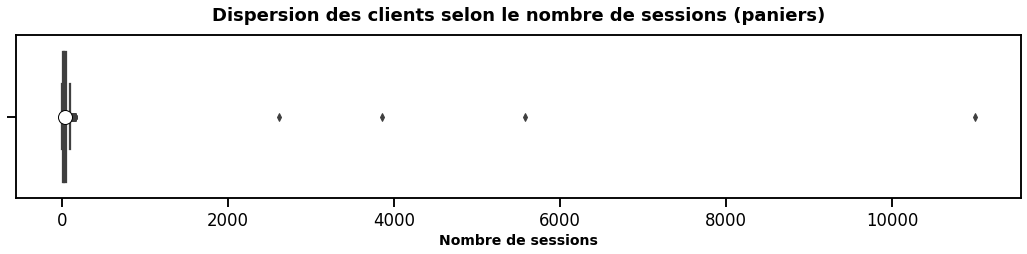

In [18]:
customers_bp = customers.copy()

plt.figure(figsize=(18,3))
sns.set_context('talk')
#sns.set_palette()
sessions_box = sns.boxplot(x='sessions_count',
                             data=customers_bp,
                             orient='h', 
                             showmeans=True,
                           showfliers=True,
                            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"14"})
plt.title("Dispersion des clients selon le nombre de sessions (paniers)", pad =15, weight='bold')
plt.xlabel('Nombre de sessions', weight = 'bold', fontsize=14)

In [19]:
# choix arbitraire de retirer les 4 principaux outliers en termes de nombre de sessions
resellers = customers.loc[(customers['sessions_count']>200)]
customers = customers.loc[(customers['sessions_count']<200)]

In [20]:
# retrait des clients au nombre de transactions atypique, que l'on nomme ici resellers
id_resellers = list(resellers['client_id'].unique())

# listing des transactions de ces "revendeurs"
trans_resellers = transactions.loc[transactions['client_id'].isin(id_resellers)]
# retrait de leurs transactions du dataframe d'origine
transactions = transactions.loc[transactions['client_id'].isin(id_resellers)==False]

print(color.BOLD + "Dataframe des transactios liées aux revendeurs\n\n" + color.END) 
trans_resellers.info()

Dataframe des transactios liées aux revendeurs


<class 'pandas.core.frame.DataFrame'>
Int64Index: 46643 entries, 2 to 679514
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id_prod     46643 non-null  object
 1   date        46643 non-null  object
 2   session_id  46643 non-null  object
 3   client_id   46643 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB


## 1.2 Reformattage des colonnes des dataframes et aperçu

In [21]:
customers_0 = customers.copy()
customers["client_id"] = customers["client_id"].astype('string')
customers["sex"] = customers["sex"].astype('category')

products_0 = products.copy()
# Reformattage des colonnes du dataframe
products["id_prod"] = products["id_prod"].astype('string')
products['categ'] = products['categ'].astype('category')

transactions_0 = transactions.copy()
# reformattage des colonnes hormis 'date' qui présnete une erreur
transactions[['id_prod','session_id',"client_id"]] = transactions[['id_prod','session_id',"client_id"]].astype('string')
transactions["date"] = pd.to_datetime(transactions["date"])

# reformattage des variables du df trans_resellers
trans_resellers[['id_prod','session_id','client_id']] = trans_resellers[['id_prod','session_id','client_id']].astype('string')
trans_resellers['date'] = pd.to_datetime(trans_resellers['date'])

In [22]:
print(color.BOLD + "Dataframe dédié aux informations clients\n\n" + color.END) 
customers.info()

Dataframe dédié aux informations clients


<class 'pandas.core.frame.DataFrame'>
Int64Index: 8596 entries, 0 to 8620
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   client_id       8596 non-null   string  
 1   sex             8596 non-null   category
 2   birth           8596 non-null   int64   
 3   sessions_count  8596 non-null   float64 
 4   trans_count     8596 non-null   float64 
dtypes: category(1), float64(2), int64(1), string(1)
memory usage: 344.3 KB


In [23]:
print(color.BOLD + "Dataframe dédié aux produits\n\n" + color.END) 
products.info()

Dataframe dédié aux produits


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3266 entries, 0 to 3265
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   id_prod  3266 non-null   string  
 1   price    3266 non-null   float64 
 2   categ    3266 non-null   category
dtypes: category(1), float64(1), string(1)
memory usage: 54.5 KB


In [24]:
print(color.BOLD + "Dataframe dédié aux transactions\n\n" + color.END) 
transactions.info()

Dataframe dédié aux transactions


<class 'pandas.core.frame.DataFrame'>
Int64Index: 632689 entries, 0 to 679531
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   id_prod     632689 non-null  string        
 1   date        632689 non-null  datetime64[ns]
 2   session_id  632689 non-null  string        
 3   client_id   632689 non-null  string        
dtypes: datetime64[ns](1), string(3)
memory usage: 24.1 MB


## 1.3 Préparation des données nécessaires à l'analyse<a class="anchor" id="prepa"></a>

### 1.3.1 Ajout de la catégorie et du prix du produit  à chaque transaction

In [25]:
transactions = pd.merge(transactions, products, on='id_prod', how='inner')

#ajout au df trans_resellers
trans_resellers = pd.merge(trans_resellers, products, on='id_prod', how='inner')

print(transactions.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 632689 entries, 0 to 632688
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   id_prod     632689 non-null  string        
 1   date        632689 non-null  datetime64[ns]
 2   session_id  632689 non-null  string        
 3   client_id   632689 non-null  string        
 4   price       632689 non-null  float64       
 5   categ       632689 non-null  category      
dtypes: category(1), datetime64[ns](1), float64(1), string(3)
memory usage: 29.6 MB
None


In [26]:
trans_resellers.dtypes

id_prod               string
date          datetime64[ns]
session_id            string
client_id             string
price                float64
categ               category
dtype: object

### 1.3.2 Enrichissement du dataframe customers

**Ajouts :**

- **<font color='red'> Âge et de la classe d'âge de chaque client</font>**
- **<font color='red'>Chiffre d'affaires par client</font>**
- **<font color='red'>Panier moyen</font>**
- **<font color='red'>Taille moyenne du panier</font>**

#### Classe d'âge

Choix basé sur [ce graphique](#age_categ) qui montre clairement une nette démarcation dans les habitudes d'achat entre les 18-30 ans, les 31-50 ans et les + de 50 ans. 

In [27]:
# ajout de l'âge basé sur l'année et le fait que "nous sommes en 2023" 
age = []

for year in customers['birth']:
    age.append(2022-year)

customers['age'] = age

# ajout d'une classe d'âge
age_class = []

for age in customers['age']:
    if 18 <= age <= 30:
        age_class.append('18-30 ans')
    if 31 <= age <= 50:
        age_class.append('31-50 ans')
    if age > 50:
        age_class.append('50 ans et +')

customers['age_class'] = age_class

# retrait de la variable 'birth'
customers = customers.drop('birth', axis=1)
customers["age_class"] = customers["age_class"].astype('category')

#### Ajout du du CA et du panier moyen

Un dataframe 'baskets' sera également créé et contiendra : 

- **session_id**
- **client_id**
- la **classe d'âge du client** (pour un hue sur la durée des sessions)
- le **montant du panier** ("session_id")
- la **date et heure de la dernière transaction**

In [28]:
# obtention du CA par panier (sessions) par le biais d'un TCD
basket_price = transactions.pivot_table(index=['session_id','client_id'],values='price', aggfunc='sum').reset_index()
# obtention du nombre de trans par panier (sessions) par le biais d'un TCD
basket_prod_count = transactions.pivot_table(index='session_id',values='id_prod', aggfunc='count').reset_index()
# pour dater le panier, on choisit la dernière date de transaction de la session 
basket_datemax = transactions.pivot_table(index='session_id',values='date', aggfunc='max').reset_index()

# merges
baskets = pd.merge(basket_price,basket_prod_count,on='session_id',how='left')
baskets = pd.merge(baskets,basket_datemax,on='session_id',how='left')
# on attribue les noms 'count_prod' pour le nombre d'articles dans le panier et 'bask_amount' pour le montant total du panier
baskets = baskets.rename(columns={'id_prod': 'count_prod', 'price':'bask_amount'})

# on va chercher les classes d'âge pour les ajouter aux informations de baskets
temp = customers[['client_id','age_class']]
baskets = pd.merge(baskets,temp,on='client_id',how='left')

# conversion de age_class en catégorie
baskets['age_class'] = baskets['age_class'].astype('category')

clients_ca = transactions.pivot_table(index=['client_id'],values='price', aggfunc='sum').reset_index()
# calcul du panier moyen par client et création d'un df dédié
clients_avg_basket = baskets.groupby('client_id')['bask_amount'].mean().reset_index()

# merge des deux df ci-dessus avec 
customers = pd.merge(customers,clients_ca, on='client_id',how='left')
customers = pd.merge(customers, clients_avg_basket, on='client_id',how='left')
customers.rename(columns={'bask_amount': 'avg_basket', 'price':'turnover'}, inplace=True)

customers['avg_bask_size'] = customers['trans_count'] / customers['sessions_count']

customers['client_id'] = customers['client_id'].astype('string')
baskets[['session_id','client_id']] = baskets[['session_id','client_id']].astype('string')



print(color.BOLD + "Dataframe des transactions liées aux paniers\n\n" + color.END) 
baskets.info()

Dataframe des transactions liées aux paniers


<class 'pandas.core.frame.DataFrame'>
Int64Index: 319274 entries, 0 to 319273
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   session_id   319274 non-null  string        
 1   client_id    319274 non-null  string        
 2   bask_amount  319274 non-null  float64       
 3   count_prod   319274 non-null  int64         
 4   date         319274 non-null  datetime64[ns]
 5   age_class    319274 non-null  category      
dtypes: category(1), datetime64[ns](1), float64(1), int64(1), string(2)
memory usage: 14.9 MB


In [29]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8596 entries, 0 to 8595
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   client_id       8596 non-null   string  
 1   sex             8596 non-null   category
 2   sessions_count  8596 non-null   float64 
 3   trans_count     8596 non-null   float64 
 4   age             8596 non-null   int64   
 5   age_class       8596 non-null   category
 6   turnover        8596 non-null   float64 
 7   avg_basket      8596 non-null   float64 
 8   avg_bask_size   8596 non-null   float64 
dtypes: category(2), float64(5), int64(1), string(1)
memory usage: 554.3 KB


In [30]:
print(color.BOLD + "Version finale du dataframe customers\n\n" + color.END) 
customers.info()

Version finale du dataframe customers


<class 'pandas.core.frame.DataFrame'>
Int64Index: 8596 entries, 0 to 8595
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   client_id       8596 non-null   string  
 1   sex             8596 non-null   category
 2   sessions_count  8596 non-null   float64 
 3   trans_count     8596 non-null   float64 
 4   age             8596 non-null   int64   
 5   age_class       8596 non-null   category
 6   turnover        8596 non-null   float64 
 7   avg_basket      8596 non-null   float64 
 8   avg_bask_size   8596 non-null   float64 
dtypes: category(2), float64(5), int64(1), string(1)
memory usage: 554.3 KB


### 1.3.3 Enrichissement du dataframe products

**Ajout :**
- **<font color='red'>Nombre de produits vendus</font>**
- **<font color='red'>Chiffre d'affaires par produit</font>** 

In [31]:
# ajout du nombre de produits vendus au df products

count_sold = transactions.groupby(by='id_prod')['client_id'].count().reset_index()
count_sold = count_sold.rename(columns={'client_id': 'count_sold'})

products = pd.merge(products, count_sold, on='id_prod', how='left')

# création des df pour les grphiques du top / flop mais qui servira aussi à ajouter le CA par produit à products
prodz_turn = transactions.pivot_table(index='id_prod', 
                                         values = 'price', 
                                         aggfunc = 'sum').reset_index()

# merge de ce df avec products pour le CA
products = pd.merge(products,prodz_turn, on='id_prod', how='left')
products = products.rename(columns={'price_x': 'price', 'price_y': 'turnover'})

# retrait des produits vendus aux resellers mais pas aux clients réguliers
products = products.loc[products['count_sold'].isnull()==False]

print(color.BOLD + "Version finale du dataframe products\n\n" + color.END)

products['id_prod'] = products['id_prod'].astype('string')

products.info()

Version finale du dataframe products


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3263 entries, 0 to 3265
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   id_prod     3263 non-null   string  
 1   price       3263 non-null   float64 
 2   categ       3263 non-null   category
 3   count_sold  3263 non-null   float64 
 4   turnover    3263 non-null   float64 
dtypes: category(1), float64(3), string(1)
memory usage: 130.8 KB


### 1.3.4 Création d'un dataframe répertoriant le CA par catégorie pour chaque clients

Ceci servira notamment à **<font color='red'>recouper avec les informations clients</font>** (âge, classe d'âge et sexe) avec celles des produits, et donc à vérifier plus tard d'éventuelles **<font color='red'>corrélations</font>**.

In [32]:
clients_categ = transactions.pivot_table(index='client_id', columns='categ',values='price',aggfunc='sum')

temp = customers[['client_id','age_class', 'age','sex']]

clients_categ = pd.merge(clients_categ, temp, on = 'client_id', how='left')
clients_categ = clients_categ.rename(columns={0: 'Catégorie 0', 1: 'Catégorie 1', 2: 'Catégorie 2'})

clients_categ['client_id'] = clients_categ['client_id'].astype('string')

print(clients_categ.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8596 entries, 0 to 8595
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   client_id    8596 non-null   string  
 1   Catégorie 0  8596 non-null   float64 
 2   Catégorie 1  8596 non-null   float64 
 3   Catégorie 2  8596 non-null   float64 
 4   age_class    8596 non-null   category
 5   age          8596 non-null   int64   
 6   sex          8596 non-null   category
dtypes: category(2), float64(3), int64(1), string(1)
memory usage: 420.0 KB
None


# 2. Analyse descriptive<a class="anchor" id="analyse"></a>

Il faut noter que les observations de cette section couvrent <font color = 'red'>**l'ensemble des données**</font>, et donc la période allant de <font color = 'red'>**mars 2021 à fin février 2023**</font>.

## 2.1 Clients

In [33]:
order_age = list(customers['age_class'].unique())
order_age.sort()

### 2.1.1 Age des clients

Ici, on peut remarquer rapidement qu'il y a un nombre anormalement élevé de clients de 18 ans; ceci ne peut s'expliquer par les données fournies, mais par les recoupements effectués plus tard, on ne peut que déduire que ces clients appartiennent bien à la classe d'âge des 18-30 ans que nous avons fixé

Text(0, 0.5, 'Nombre de clients')

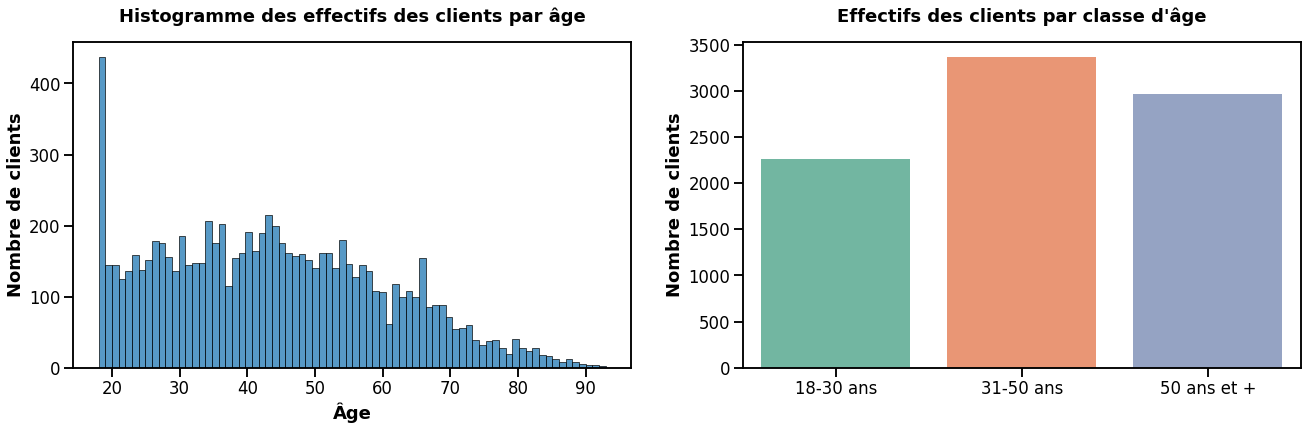

In [34]:
sns.set_context('talk')

fig,axs = plt.subplots(1,2)
fig.set_figwidth(22)
fig.set_figheight(6)

bins = len(customers['age'].unique())

fig1 = sns.histplot(customers['age'],ax=axs[0], bins=bins)
axs[0].set_title("Histogramme des effectifs des clients par âge", fontsize=18,weight='bold', pad= 20)
axs[0].set_xlabel("Âge", weight = 'bold')
axs[0].set_ylabel("Nombre de clients", weight = 'bold')


ageclass_count = customers.groupby('age_class')['client_id'].count().reset_index()

fig2 = sns.barplot(x='age_class', y='client_id', data=ageclass_count,ax=axs[1],palette='Set2')
axs[1].set_title("Effectifs des clients par classe d'âge", fontsize=18,weight='bold', pad= 20)
axs[1].set_xlabel("")
axs[1].set_ylabel("Nombre de clients", weight = 'bold')

La définition des **classes d'âge** ci-dessus s'avère être justifiée lorsque l'on recoupe **âge et chiffre d'affaire par catégorie**. On remarque facilement :

- la forte popularité des produits de la <font color = 'red'>**catégorie 2**</font> chez les <font color = 'red'>**18-30 ans**</font>
- l'affection des <font color = 'red'>**31-50 ans**</font> pour les produits de la <font color = 'red'>**catégorie 0**</font>
- la popularité quelque croissante de la <font color = 'red'>**catégorie 1**</font> lorsque l'on avance en âge, <font color = 'red'>**à partir des 30-40 ans**</font>

Il faut noter que l'on remarque une **sur-représentation des clients de 18 ans**, certainement due à des informations erronées et une potentielle inclusion d'un public plus mineur. Quoiqu'il en soit, **les client de 18 ans semblent observer un même type de comportement d'achat que les 18-30 ans** dans l'ensemble, ce qui justifie dans les inclure dans cette classe.  

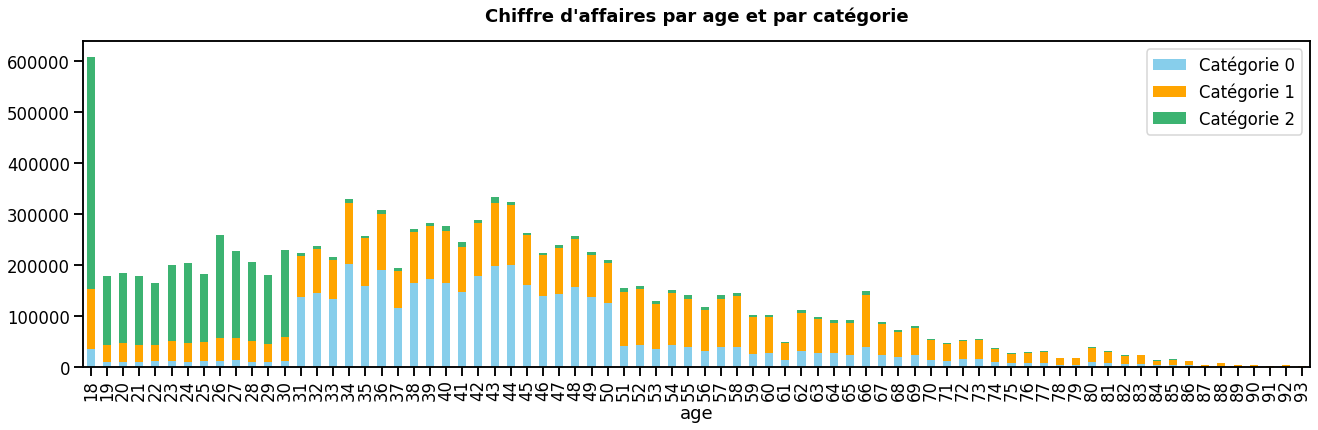

In [35]:
# attribution d'une couleur par produit
colors_prodz= ['skyblue', 'orange','mediumseagreen']

stacked_graph = clients_categ.groupby('age').sum().plot(kind='bar',stacked=True, color=colors_prodz)
plt.title("Chiffre d'affaires par age et par catégorie", fontsize=18, weight='bold',pad=20)
plt.gcf().set_size_inches(22, 6)
legend = plt.legend(bbox_to_anchor=(1,1))
legend.get_texts()[0].set_text('Catégorie 0')
legend.get_texts()[1].set_text('Catégorie 1')
legend.get_texts()[2].set_text('Catégorie 2')

### 2.1.2 Recoupement entre âge, chiffre d'affaires, panier moyen et genre

In [36]:
# couleurs attribuées aux genres
colors_sex = ['lightseagreen','khaki']

A la vue des graphiques ci-dessous, une conclusion s'impose rapidement : la <font color ='red'>**grande similarité des tailles d'effectifs féminins et masculins de la clientèle sur ces 3 points de vue**</font>. La catégorie liée au genre ne nous apportera donc sans doute pas de renseignements utiles. 

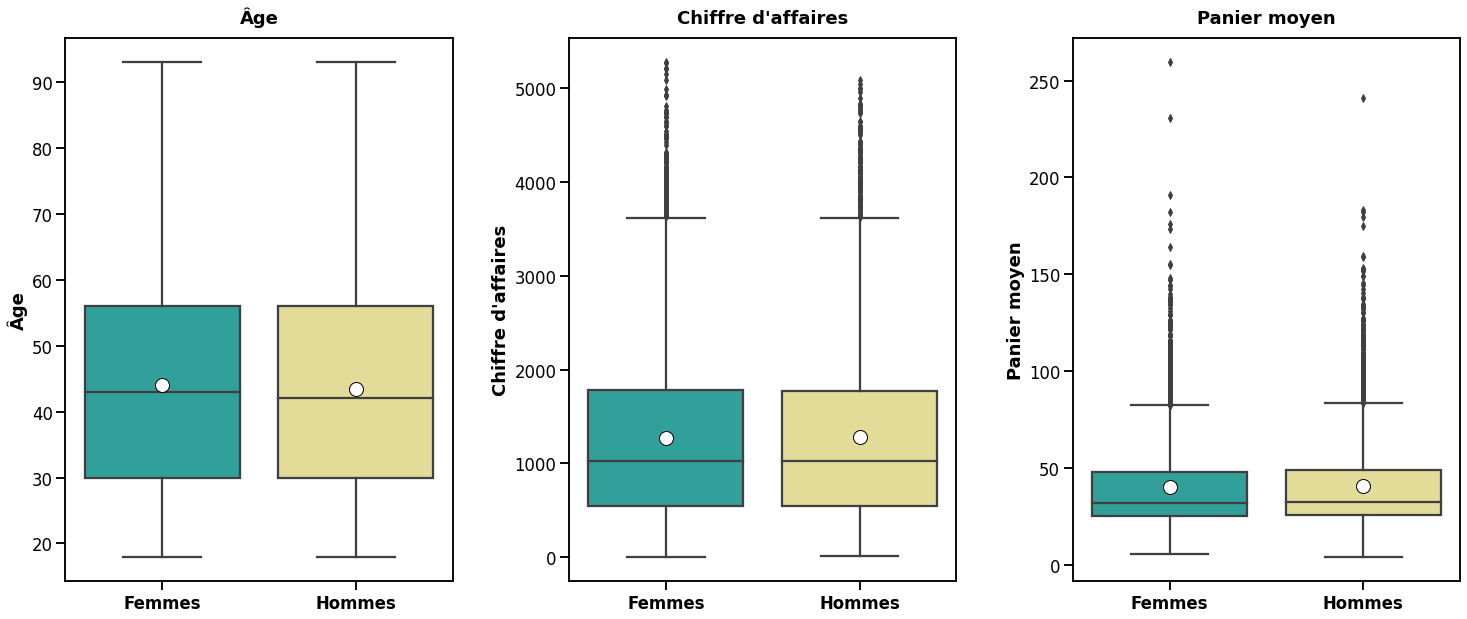

In [37]:
fig, axs = plt.subplots(1,3)

fig.set_figwidth(25)
fig.set_figheight(10)

sns.set_context('talk')
sns.set_palette(colors_sex)

sns.boxplot(ax=axs[0],x='sex', y='age', data=customers, 
                             showmeans=True,
                            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"14"})
axs[0].set_xlabel("")
axs[0].set_ylabel("Âge", weight='bold')
axs[0].set_title("Âge", pad =15, weight='bold')
axs[0].set_xticks([0,1],['Femmes','Hommes'], weight='bold')

sns.boxplot(ax=axs[1],x='sex', y='turnover', data=customers, 
                             showmeans=True,
                            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"14"})
axs[1].set_xlabel("")
axs[1].set_ylabel("Chiffre d'affaires", weight='bold')
axs[1].set_title("Chiffre d'affaires", pad =15, weight='bold')
axs[1].set_xticks([0,1],['Femmes','Hommes'], weight='bold')

sns.boxplot(ax=axs[2],x='sex', y='avg_basket', data=customers, 
                             showmeans=True,
                            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"14"})
axs[2].set_xlabel("")
axs[2].set_ylabel("Panier moyen", weight='bold')
axs[2].set_title("Panier moyen", pad =15, weight='bold')
axs[2].set_xticks([0,1],['Femmes','Hommes'], weight='bold')

plt.subplots_adjust(wspace=0.3)
plt.show()

### 3.1.3 CA et panier moyen par classe d'âge

**Les informations liées aux classes d'âge nous apporte quant à elle beaucoup plus d'informations intéressantes :**

- le <font color = 'red'>**chiffre d'affaires moyen le plus élevé**</font> appartient à la classe d'âge des <font color = 'red'>**31-50 ans**</font>
- le <font color = 'red'>**panier moyen est nettement plus élevée pour les 18-30 ans**</font> que pour les autres classes d'âge
- les <font color = 'red'>**40-49 ans**</font> observent une <font color = 'red'>**fréquence d'achat (nombre de sessions) plus élevée**</font>, les 18-24 ans affichant la plus faible 

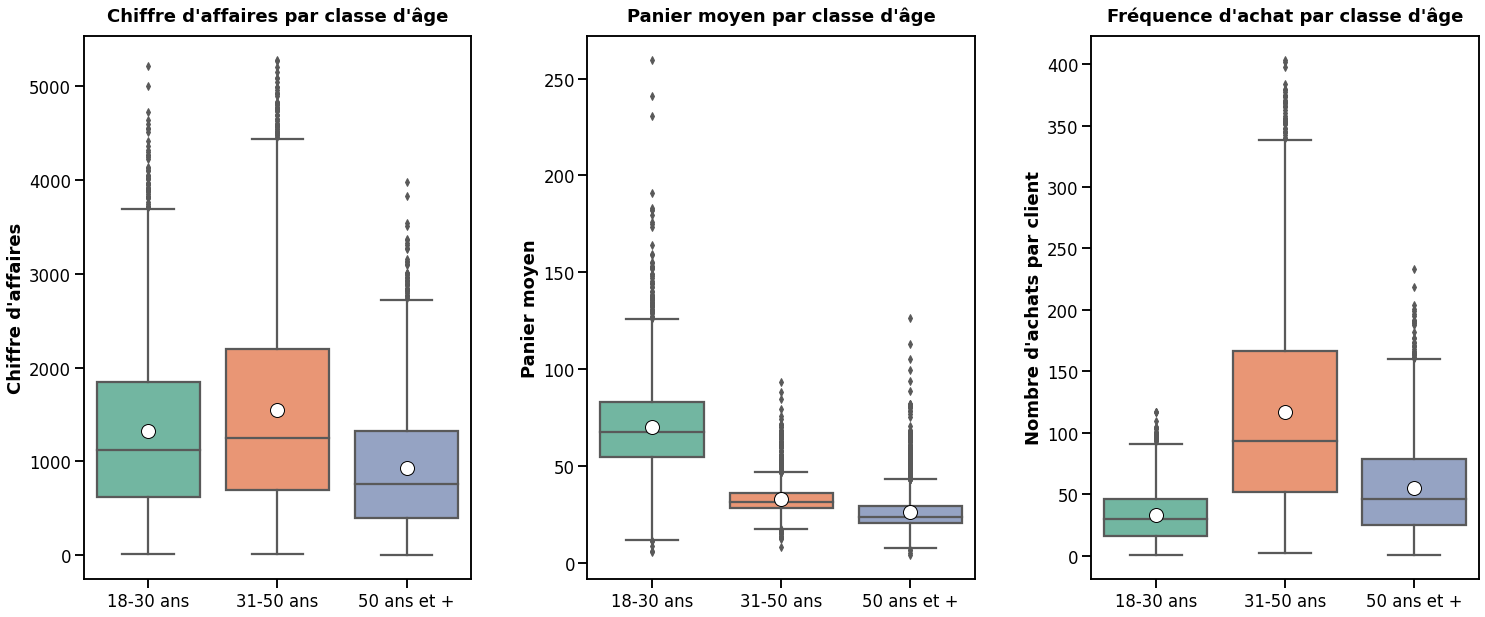

In [38]:
fig, axs = plt.subplots(1,3)

fig.set_figwidth(25)
fig.set_figheight(10)

sns.set_context('talk')
sns.set_palette('Set2')

sns.boxplot(ax=axs[0],x='age_class', y='turnover', data=customers, order=order_age, 
                             showmeans=True,
                            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"14"})
axs[0].set_xlabel("")
axs[0].set_ylabel("Chiffre d'affaires", weight='bold')
axs[0].set_title("Chiffre d'affaires par classe d'âge", pad =15, weight='bold')

sns.boxplot(ax=axs[1],x='age_class', y='avg_basket', data=customers, order=order_age, 
                             showmeans=True,
                            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"14"})
axs[1].set_xlabel("")
axs[1].set_ylabel("Panier moyen", weight='bold')
axs[1].set_title("Panier moyen par classe d'âge", pad =15, weight='bold')


sns.boxplot(ax=axs[2],x='age_class', y='trans_count', data=customers, order=order_age, 
                             showmeans=True,
                            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"14"})
axs[2].set_xlabel("")
axs[2].set_ylabel("Nombre d'achats par client", weight='bold')
axs[2].set_title("Fréquence d'achat par classe d'âge", pad =15, weight='bold')

plt.subplots_adjust(wspace=0.3)

plt.show()

## 2.2 Les produits

Comme indiqué plus haut lors du nettoyage, <font color ='red'>**le prix moyen de la catégorie 0 a été choisi pour être appliqué au produit de la référence 0_2245**</font>. Ce choix est justifié par le fait que la moyenne se trouve proche de la médiane, comme on peut le voir dans le premier des 3 grahiques ci-dessous. <a class="anchor" id="bp_prices"></a>

**Notes :**
- le premier graphique montre que les catégories sont définies par leur prix, en asbcence d'informations plus précises sur leur nature
- le CA moyen et l'amplitude du CA des produits augmente donc avec la catégorie
- les catégories 0 et 2 ont des fréquences de vente relativement proches, mais la catégorie 1 se démarque nettement par son nombre moyen d'articles vendus 

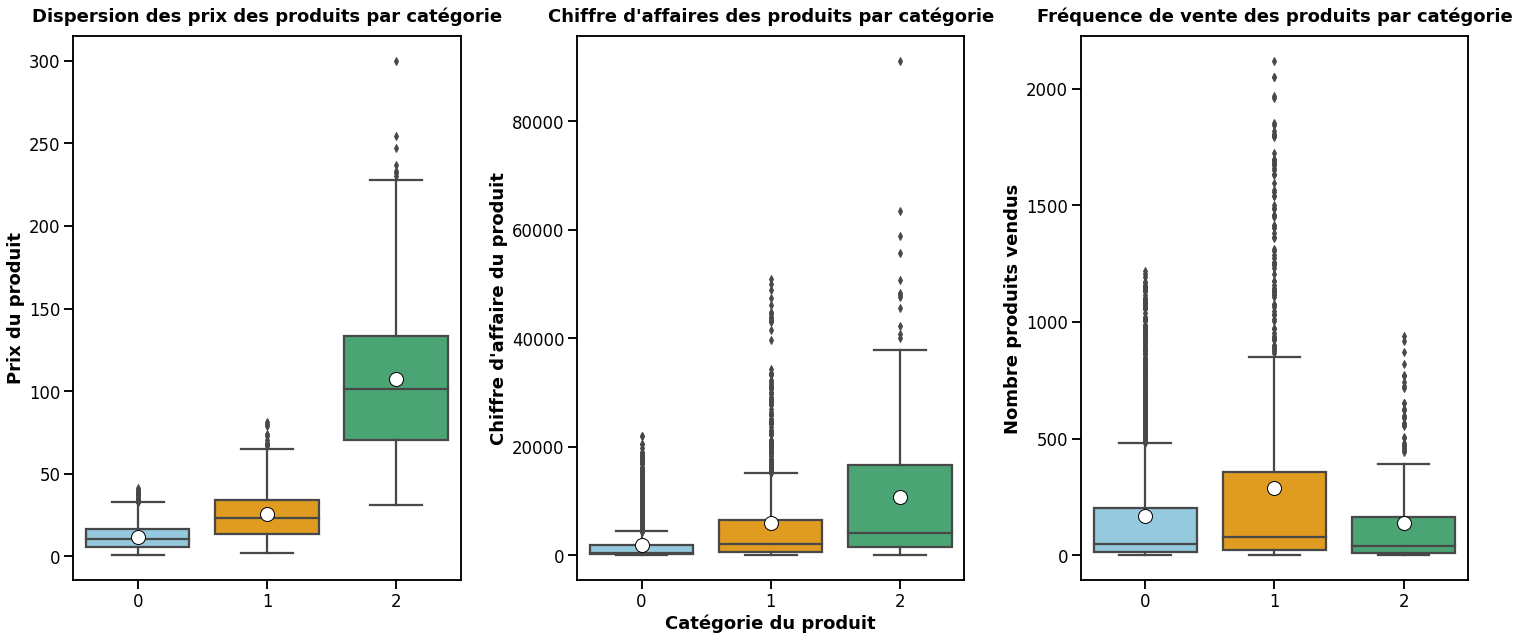

In [39]:
sns.set_palette(colors_prodz)
sns.set_context('talk')
fig,axs = plt.subplots(1,3)

fig.set_figwidth(25)
fig.set_figheight(10)

cat_prices_box = sns.boxplot(y='price',x='categ',
                             data=products, ax=axs[0],
                             orient='v', 
                             showmeans=True,
                            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"14"})
axs[0].set_title("Dispersion des prix des produits par catégorie", fontsize= 18, pad =15, weight='bold')
axs[0].set_ylabel('Prix du produit', weight= 'bold')
axs[0].set_xlabel('')

cat_turn_box = sns.boxplot(y='turnover',x='categ',
                             data=products,
                             orient='v', 
                             showmeans=True,
                             ax=axs[1],
                            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"14"},
                            showfliers=True)
axs[1].set_title("Chiffre d'affaires des produits par catégorie", fontsize= 18, pad =15, weight='bold')
axs[1].set_xlabel('Catégorie du produit', weight= 'bold')
axs[1].set_ylabel("Chiffre d'affaire du produit", weight='bold')

cat_turn_box = sns.boxplot(y='count_sold',x='categ',
                             data=products,
                             orient='v', 
                             showmeans=True,
                             ax=axs[2],
                            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"14"},
                            showfliers=True)
axs[2].set_title("Fréquence de vente des produits par catégorie", fontsize= 18, pad =15, weight='bold')
axs[2].set_ylabel("Nombre produits vendus", weight='bold')
axs[2].set_xlabel('')

plt.subplots_adjust(wspace=0.3)



## 2.3 Transactions

- observation du nombre de ventes dans le temps afin de détecter les anomalies. Deux points cruciaux à noter :
    - une <font color ='red'>**baisse anormale des ventes en octobre 2021**</font> dont l'observation montre qu'elle ait due à un arrêt total des ventes de la catégorie 1 pendant presque 1 mois. Les données de ce mois seront donc interpolées pour pouvoir étudier la tendance.
    - une autre <font color ='red'>**chute anormale au mois de février 2023**</font>, mais celle-ci ne semble pas explicable de par les données à disposition. Ce mois sera lui aussi retiré lors des calculs visant à estimer une tendance.

In [40]:
turn_total = transactions.groupby(pd.Grouper(key='date',freq='M'))['price'].sum()

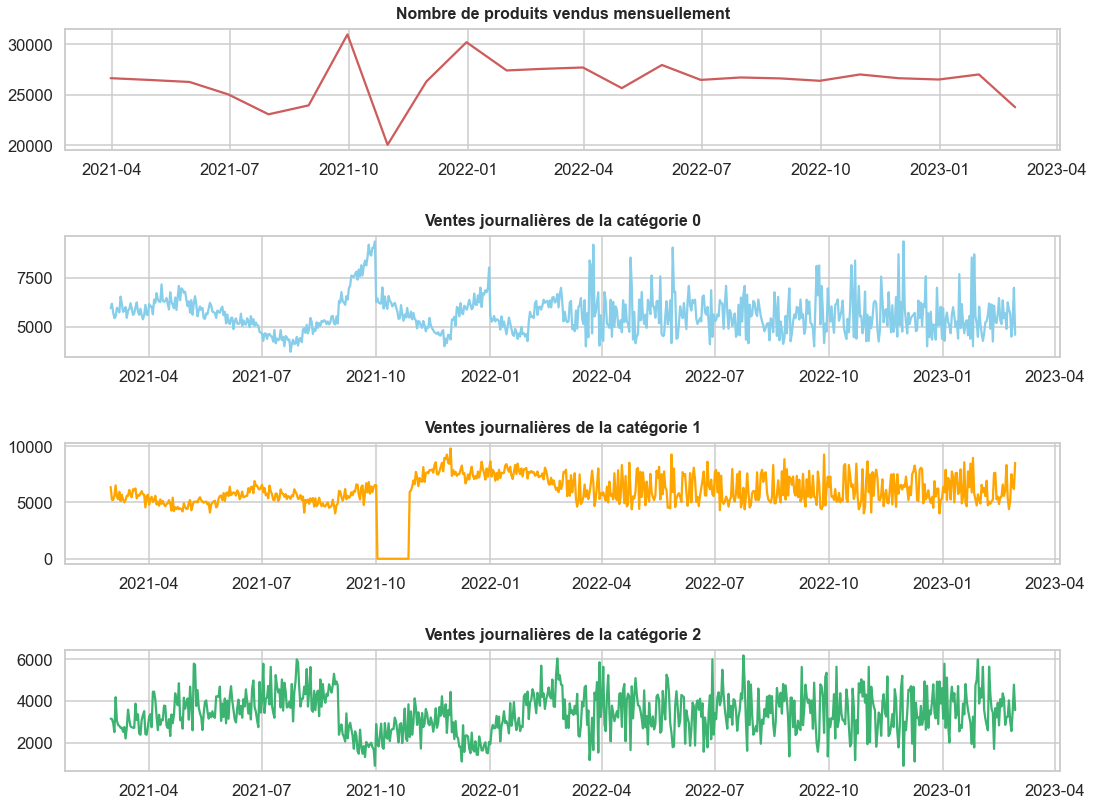

In [41]:
sns.set_style("whitegrid")

# données des ventes journalières par catégorie pour essayer de justifier les anomalies
categ0_day = transactions.loc[transactions['categ']==0].groupby(pd.Grouper(key='date', freq='D'))['price'].sum()
categ1_day = transactions.loc[transactions['categ']==1].groupby(pd.Grouper(key='date', freq='D'))['price'].sum()
categ2_day = transactions.loc[transactions['categ']==2].groupby(pd.Grouper(key='date', freq='D'))['price'].sum()

fig, axs = plt.subplots(4)

fig.set_figwidth(16)
fig.set_figheight(12)

#line_graph = transactions.groupby(pd.Grouper(key='date', freq='M'))['id_prod'].count().plot(kind='line', color='indianred')

axs[0].plot(transactions.groupby(pd.Grouper(key='date', freq='M'))['id_prod'].count(),color='indianred')
axs[0].set_title("Nombre de produits vendus mensuellement", pad = 10, fontsize= 16, weight='bold')

axs[1].plot(categ0_day, color=colors_prodz[0])
axs[1].set_title("Ventes journalières de la catégorie 0", pad = 10, fontsize= 16, weight='bold')

axs[2].plot(categ1_day, color=colors_prodz[1])
axs[2].set_title("Ventes journalières de la catégorie 1", pad = 10, fontsize= 16, weight='bold')

axs[3].plot(categ2_day, color=colors_prodz[2])
axs[3].set_title("Ventes journalières de la catégorie 2", pad = 10, fontsize= 16, weight='bold')


fig.tight_layout(pad=2.0)

### Correction des anomalies

**Ici, correction des anomalies constatées :** 
- retrait des **<font color='red'> transactions liées au mois d'octobre 2021 et interpolation du résultat</font>** pour le même mois
- **<font color='red'> mois de février 2023 ignoré</font>** car impossible de savoir s'il y a des données manquantes

In [42]:
# chiffre d'affaires par catégorie, par mois
turn_categ = transactions.pivot_table(index='date',
                                                         columns='categ', 
                                                         values = 'price', 
                                                         aggfunc='sum').reset_index()

# chiffre d'affaires par mois pour la catégorie 0
categ0 = turn_categ.groupby(pd.Grouper(key='date', freq='M'))[0].sum()

# chiffre d'affaires par mois pour la catégorie 1
categ1 = turn_categ.groupby(pd.Grouper(key='date', freq='M'))[1].sum()

# correction de l'anomalie en enlevant les résultats associés au mois d'octobre 2021
# et en ajoutant des résultats à partir d'une interpolation
categ1.iloc[7] = None
categ1 = categ1.interpolate(method ='linear', limit_direction ='forward')

# # chiffre d'affaires par mois pour la catégorie 2
categ2 = turn_categ.groupby(pd.Grouper(key='date', freq='M'))[2].sum()

## 3. Chiffre d'affaires<a class="anchor" id="ca"></a>

Ci-dessous, un aperçu de  **<font color='red'>la tranche retirée de l'analyse</font>** qui suit, c'est-à-dire la part des **<font color='red'>4 clients au nombre de transactions atypique</font>** (les revendeurs).

On commencera par évaluer la tendance générale du chiffre d'affaire, puis par catégorie. 


**Pour rappel**, les informations suivantes sont à prendre en considération pour les **tendances du chiffres d'affaires** :

- <font color='red'>**le CA du mois d'octobre 2021 a été corrigé par interpolation**</font> afin de pallier l'anomalie observée, c'est-à-dire l'arrêt des ventes de la catégorie 0 pendant presque un mois.
- <font color='red'>**le mois de février 2023 à été ignoré**</font> en raison d'une baisse anormale des ventes qui n'a pu être expliquée; celle-ci aurait irémémiadlement biaisé les résultats pour ce tendances.




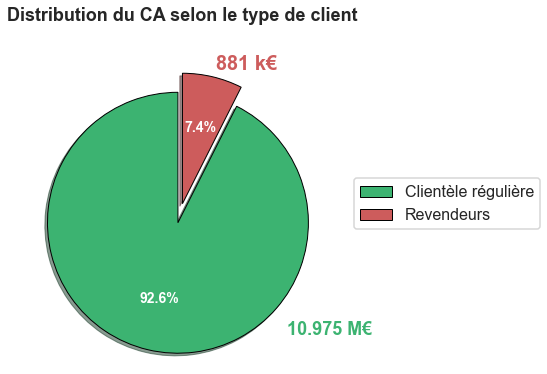

In [43]:
# prépration des données pour le graphique : chiffre d'affaires des revendeurs et des clients dit réguliers

#CA des revenderus
turn_resellers = trans_resellers['price'].sum()
#CA total des clients réguliers
turnover = customers['turnover'].sum()
# préparation de données pour le graphique
total_turnover = [turnover,turn_resellers]


# création des labels à partir des données
result_resellers = ["",str(int(turn_resellers/1000)) + " k€"]
result_normal = ["",str(round(turnover/1000000,3)) + " M€"]
labels = ['Clientèle régulière', 'Revendeurs']

# règlages de l'explode
explode = (0.15, 0.0)
 
# choix des couleurs
colors = ['mediumseagreen','indianred']
 
# Propriétés des bordures
wp = { 'linewidth' : 1, 'edgecolor' : "black" }
 
# Creating autocpt arguments
def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%".format(pct, absolute)
 
# Création du graphique
fig, ax = plt.subplots(figsize =(12, 6))
wedges, texts, autotexts = ax.pie(total_turnover,
                                  autopct = lambda pct: func(pct, total_turnover),
                                  explode = explode,
                                  labels = result_resellers,
                                  shadow = True,
                                  colors = colors,
                                  startangle = 90,
                                  wedgeprops = wp,
                                  textprops = dict(color ="indianred", fontsize = 20, weight='bold'))

[autotext.set_color('white') for autotext in autotexts]
texts[0].set_fontsize(25)

 
# Adding legend
ax.legend(wedges, labels,
          loc ="center left",
          bbox_to_anchor =(1, 0, 0.5, 1),
         fontsize=16)
 
plt.setp(autotexts, size = 14, weight ="bold")
ax.set_title("Distribution du CA selon le type de client", fontsize=18, weight='bold', pad =20)

plt.text(0.8, -1, result_normal[1], fontsize=18, weight='bold', color='mediumseagreen')
 
# show plot
plt.show()

## 3.1 Tendances du chiffre d'affaires<a class="anchor" id="trend_ca"></a>

Pour obtenir un aperçu de la tendance d'une chiffre d'affaires, j'ai opté ici pour une moyenne mobile centrée de 12 mois. Comme expliqué un peu plus, les anomalies observées pour le mois d'octobre 2021 ainsi que février 2023 ont été corrigées dans le premier cas, ignorées dans le second.

**Ici, on peut remarquer :**

- <font color='red'>tendance à la **hausse du chiffre d'affaires global**</font>
- une légère tendance à la baisse de la catégorie 0
- pas de véritable tendance pour la catégorie 1
- une légère tendance à la hausse de la catégorie 2

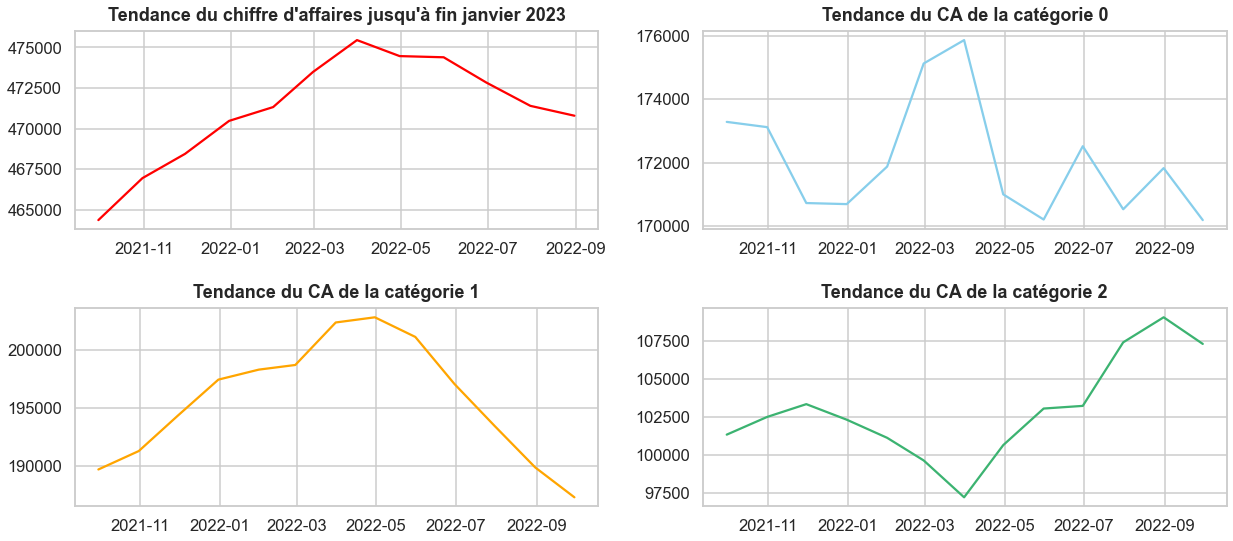

In [44]:
# Moyenne mobile avec fenêtre centrée sur 12 mois piur donner la tendance
# retrait de février 2023 dont les résultast semblentrelever de l'anomalie et qui influencerait trop la tendance

#### Tendance générale du CA

sns.set_context('talk')

list_date = categ0.reset_index()['date']

turn = np.array(categ0)+np.array(categ1)+np.array(categ2)
turn = pd.DataFrame(turn)
turn['date'] = list_date

# retrait du mois de février 2023 en raison d'une chute inexpliquée qui pourrait fausser la tendance
turn_trend = turn.loc[turn['date']<'2023-02-01']
turn_trend = turn_trend.set_index('date')
categ0_trend = categ0.reset_index()
categ0_trend = categ0_trend.loc[categ0_trend['date']<'2023-02-01']
categ1_trend = categ1.reset_index()
categ1_trend = categ1_trend.loc[categ1_trend['date']<'2023-02-01']
categ2_trend = categ2.reset_index()
categ2_trend = categ2_trend.loc[categ2_trend['date']<'2023-02-01']


fig, axs = plt.subplots(2,2)

fig.set_figwidth(20)
fig.set_figheight(6)

# paramètres de la moyenne mobile
rolling = 12
center = True

axs[0,0].plot(turn_trend.rolling(rolling, center=True).mean(), color='red')
axs[0,0].set_title("Tendance du chiffre d'affaires jusqu'à fin janvier 2023", pad = 10, weight='bold')
axs[0,1].plot(categ0.rolling(rolling,center=center).mean(), label = "Catégorie 0", color=colors_prodz[0])
axs[0,1].set_title('Tendance du CA de la catégorie 0', pad = 10, weight='bold')
axs[1,0].plot(categ1.rolling(rolling,center=center).mean(), label = "Catégorie 1", color=colors_prodz[1])
axs[1,0].set_title('Tendance du CA de la catégorie 1', pad = 10, weight='bold')
axs[1,1].plot(categ2.rolling(rolling,center=center).mean(), label = "Catégorie 2", color=colors_prodz[2])
axs[1,1].set_title('Tendance du CA de la catégorie 2', pad = 10, weight='bold')

# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=1.2, 
                    wspace=0.2, 
                    hspace=0.4)

plt.show()

## 3.2 Chiffre d'affaires par clients<a class="anchor" id="ca_clients"></a>

La courbe de Lorenz ci-dessous est appliquée à la distribution du chiffre d'affaires parmi les clients de la librairie sur l'ensemble de la période donnée (Mars 2021 - Févrirer 2023).

Le **coffecient de Gini** est calculé de la manière suivante :

**Aire A / (Aire A + Aire B)**

Plus cet indicateur est important, autrement dit plus il tend vers 1, plus il nous indique que la distribution de la valeur mesurée est innégale parmi les effectifs. <font color='red'>**Ici, étant de 0.4, il nous indique qu'il existe une inégalité modérée.**</font>

<font color='red'>**Autre lecture du graphique**</font>, indiquée par les lignes pointillées de référence en rouge : <font color='red'>**environ 52% de la clientèle rapporte 80% du chiffre d'affaires.**</font>



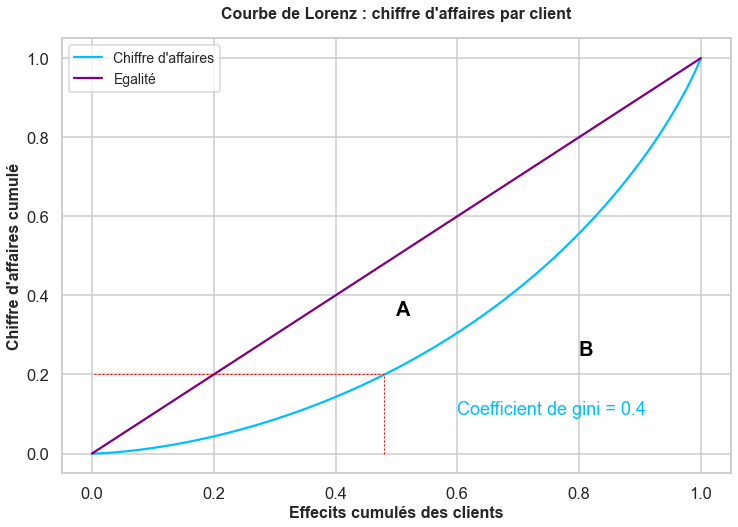

In [45]:
ca = customers['turnover']
ca = np.array(ca)
f_vals, l_vals = qe.lorenz_curve(ca)
gini = qe.gini_coefficient(ca)

fig, ax = plt.subplots()
fig.set_figwidth(12)
fig.set_figheight(8)
lorenz_line = ax.plot(f_vals, l_vals, label="Chiffre d'affaires", color='deepskyblue')
ax.plot(f_vals, f_vals, label='Egalité', color= 'purple')
plt.title("Courbe de Lorenz : chiffre d'affaires par client", fontsize=16, weight = 'bold', pad=20)
ax.text(0.6, 0.1, f"Coefficient de gini = {round(gini,2)}", fontsize=18, color='deepskyblue')
ax.text(0.5, 0.35, "A", fontsize=20, color='Black', weight='bold')
ax.text(0.8, 0.25, "B", fontsize=20, color='Black', weight='bold')
plt.plot([0.48, 0.48, 0], [0, 0.2, 0.2], lw=1,dashes=[2, 2], color='red')
plt.xlabel("Effecits cumulés des clients",weight='bold',fontsize=16)
plt.ylabel("Chiffre d'affaires cumulé",weight='bold',fontsize=16)
plt.grid('darkgrid')
ax.legend(fontsize=14)
plt.show()

#### Comparaison entre les 52% des meilleurs clients et les 48% restants



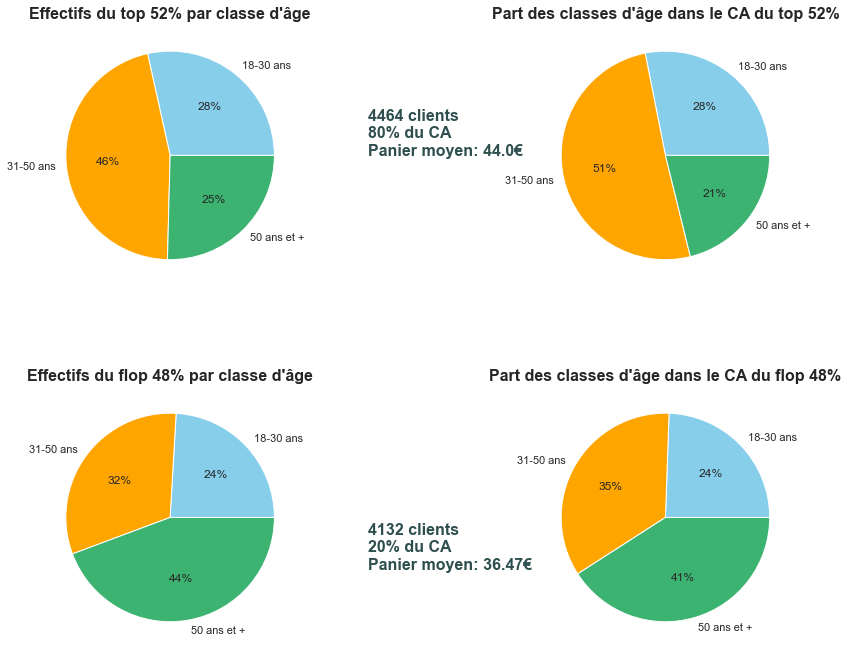

In [46]:
#classement des customers en fonction de leur CA
customers['rank'] = customers['turnover'].rank(ascending=False)
customers.sort_values('turnover', inplace=True, ascending=False)

# utilisation de cumsum() pour pouvoir créer un top x%
customers['cumsum'] = customers['turnover'].cumsum()
customers['cum%'] = customers['cumsum']/customers['turnover'].sum()*100

top_customers = customers.loc[customers['cum%']<80]
tbd = ['rank','cumsum','cum%']
top_customers = top_customers.drop(top_customers[tbd], axis=1)

# on établit la liste des ids des clients qui rapportent le plus (80% du CA, soit environ 52% des effectifs)
top_cust_id = list(top_customers['client_id'].unique())
# création d'un échantillon des cllients qui rapportent le moins
customers_other = customers.loc[customers['client_id'].isin(top_cust_id)==False]
customers_other = customers_other.drop(customers_other[tbd], axis=1)

# effectifs ^par classe d'âge pour les deux groupes
top_cust_count = top_customers.groupby('age_class')['client_id'].count()
cust_other_count = customers_other.groupby('age_class')['client_id'].count()

# chiffres d'affaires par classe d'âge pour les deux groupes
top_cust_turn = top_customers.groupby('age_class')['turnover'].sum()
cust_other_turn = customers_other.groupby('age_class')['turnover'].sum()

############ Graphiques ####################################

sns.set_context('notebook')

fig, axs = plt.subplots(2,2)
fig.set_figwidth(15)
fig.set_figheight(8)

pie1 = axs[0,0].pie(top_cust_count,labels=order_age,autopct='%1.f%%')
axs[0,0].set_title("Effectifs du top 52% par classe d'âge",size=16,weight='bold')
axs[0,0].text(1.9,0,f"{len(top_customers)} clients\n80% du CA\nPanier moyen: {round(top_customers['avg_basket'].mean(),2)}€",
              size=16,color='darkslategrey',weight='bold')
pie2 = axs[0,1].pie(top_cust_turn,labels=order_age,autopct='%1.f%%')
axs[0,1].set_title("Part des classes d'âge dans le CA du top 52%",size=16,weight='bold')
pie1 = axs[1,0].pie(cust_other_count,labels=order_age,autopct='%1.f%%')
axs[1,0].set_title("Effectifs du flop 48% par classe d'âge",size=16,weight='bold')
axs[1,0].text(1.9,-0.5,f"{len(customers_other)} clients\n20% du CA\nPanier moyen: {round(customers_other['avg_basket'].mean(),2)}€",
              size=16,color='darkslategrey',weight='bold')
pie2 = axs[1,1].pie(cust_other_turn,labels=order_age,autopct='%1.f%%')
axs[1,1].set_title("Part des classes d'âge dans le CA du flop 48%",size=16,weight='bold')

plt.subplots_adjust(left=0,
                    bottom=0.1, 
                    right=0.7, 
                    top=1.3, 
                    wspace=0.9, 
                    hspace=0.1)

### 3.2.1 Effectifs et chiffre d'affaires des clients selon le sexe et l'âge<a class="anchor" id="ca_age_sex"></a>

C:\Users\ybleb\anaconda3\lib\site-packages\ipykernel_launcher.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator


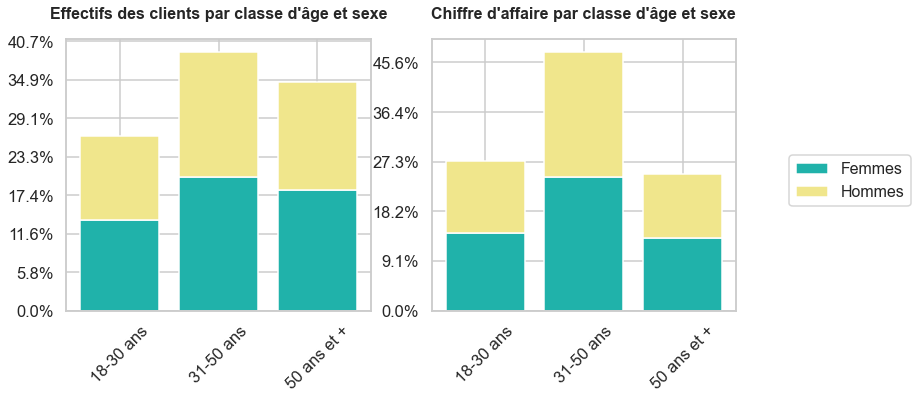

In [47]:
# création tableau croisé classe d'âge / sexe pour dénombrer les effectifs de chaque classe d'âge
bar_ages = customers.pivot_table(index='age_class', 
                                 columns = 'sex', 
                                 values='client_id', 
                                 aggfunc='count').reset_index()

# création tableau croisé classe d'âge / sexe pour évaluer la proportion de chaque classe d'âge dans le CA 
bar_turn_ages = customers.pivot_table(index='age_class', 
                                 columns = 'sex', 
                                 values='turnover', 
                                 aggfunc='sum').reset_index()

# création des proportions de représentation de chaque classe d'âge pour les labels de haut de graph
bar_ages['%'] = round((bar_ages['f'] + bar_ages['m']) / (bar_ages['f'].sum() + bar_ages['m'].sum())*100)
bar_turn_ages['%'] = round((bar_turn_ages['f'] + bar_turn_ages['m']) / (bar_turn_ages['f'].sum() + bar_turn_ages['m'].sum())*100)

################ Graphiques ################

labels_bars = ['Femmes','Hommes']

sns.set_context('talk')

fig, axs = plt.subplots(1,2)

fig.set_figwidth(12)
fig.set_figheight(5)

axs[0].bar(bar_ages['age_class'],bar_ages['f'],color= colors_sex[0])
axs[0].bar(bar_ages['age_class'],bar_ages['m'],bottom=bar_ages['f'],color= colors_sex[1])
axs[0].yaxis.set_major_formatter(mtick.PercentFormatter(len(customers)))
axs[0].set_title("Effectifs des clients par classe d'âge et sexe", fontsize =16, weight='bold', pad=20)


axs[1].bar(bar_turn_ages['age_class'],bar_turn_ages['f'],color= colors_sex[0])
axs[1].bar(bar_turn_ages['age_class'],bar_turn_ages['m'],bottom=bar_turn_ages['f'],color= colors_sex[1])
axs[1].yaxis.set_major_formatter(mtick.PercentFormatter(turnover))
axs[1].set_title("Chiffre d'affaire par classe d'âge et sexe", fontsize =16, weight='bold', pad=20) 

for n, ax in enumerate(axs):
    ax.set_xticklabels(bar_ages['age_class'], rotation=45)

plt.legend(labels_bars, 
           bbox_to_anchor=(1.6,0.6), 
           loc="upper right", fontsize=16)



plt.show()

In [48]:
bar_ages

sex,age_class,f,m,%
0,18-30 ans,1179,1087,26.0
1,31-50 ans,1733,1632,39.0
2,50 ans et +,1566,1399,34.0


In [49]:
bar_turn_ages

sex,age_class,f,m,%
0,18-30 ans,1553601.92,1451546.20,27.0
1,31-50 ans,2692287.58,2522506.83,48.0
2,50 ans et +,1461494.52,1293743.61,25.0


## 3.3 CA par produits<a class="anchor" id="turn_prodz"></a>

La démarche est ici de déterminer quels sont les produits qui se vendent le mieux en utilisant une courbe de Lorenz, puis un classement avec le chiffre d'affaire cumulé de ces produits. L'ordre de classement va bien sûr du produit générant le plus de chiffre d'affaires à celui qui en génére le moins.

Avez la courbe de Lorenz ci-dessous, on s'aperçoit qu'environ <font color='red'>**22% des produits rapportent environ 80% du chiffre d'affaires**.</font> Cette distribution ne paraît véritablement surprenante, mais nous utiliserons ce fait pour identifier ces produits qui se vendent mieux et en tirer des conclusions.

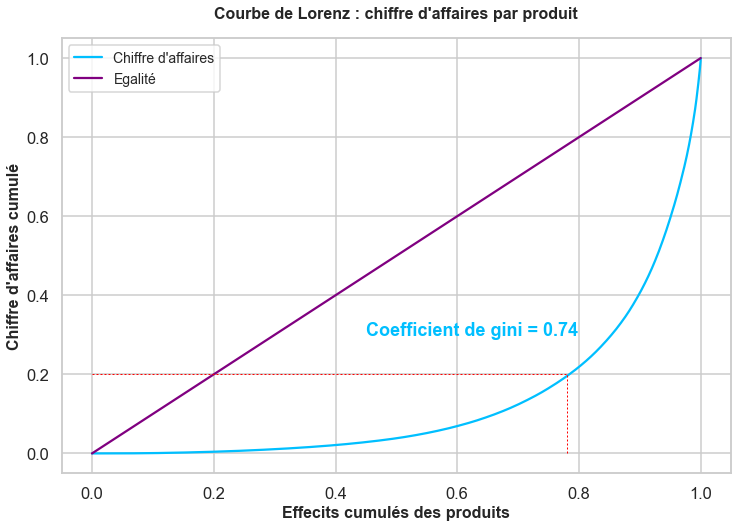

In [50]:
prodz = np.array(products['turnover'])

f_vals, l_vals = qe.lorenz_curve(prodz)

gini_prod = qe.gini_coefficient(prodz)

fig, ax = plt.subplots()
fig.set_figwidth(12)
fig.set_figheight(8)
ax.plot(f_vals, l_vals, label="Chiffre d'affaires", color='deepskyblue')
ax.plot(f_vals, f_vals, label='Egalité',color='purple')
plt.title("Courbe de Lorenz : chiffre d'affaires par produit", fontsize=16, weight = 'bold', pad=20)
ax.text(0.45, 0.3, f"Coefficient de gini = {round(gini_prod,2)}", fontsize=18, color='deepskyblue',weight='bold')
plt.plot([0.78, 0.78, 0], [0, 0.2, 0.2], lw=1,dashes=[2, 2], color='red')
plt.xlabel("Effecits cumulés des produits",weight='bold',fontsize=16)
plt.ylabel("Chiffre d'affaires cumulé",weight='bold',fontsize=16)
plt.grid('darkgrid')
ax.legend(fontsize=14)
plt.show()

In [51]:
# reclassement des produits par le CA, du plus élevé au plus faible
products_sorted = products.sort_values(by='turnover',ascending=False)

# utilisation de cumsum() pour pouvoir créer un top x%
products_sorted['cumsum'] = products_sorted['turnover'].cumsum()
products_sorted['cum%'] = products_sorted['cumsum']/products_sorted['turnover'].sum()*100
top_products = products_sorted.loc[products_sorted['cum%']<=80]

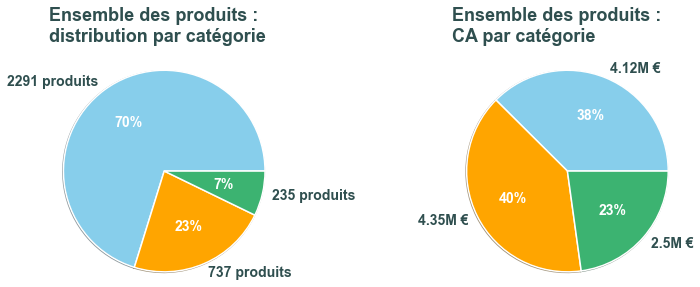

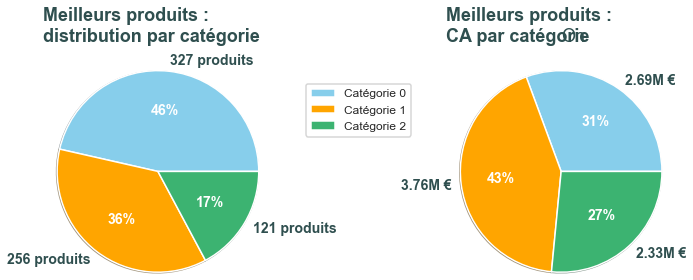

In [52]:
count_prod_categ = list(products.groupby(by='categ')['id_prod'].count())

turn_categ = list(transactions.groupby(by='categ')['price'].sum())
labels = ['Catégorie 0','Catégorie 1','Catégorie 2']

# création des labels de chaque camembert : 
#nombre de produits pour le 1er, CA our le 2ème 
labels_count_categ = [str(count) + ' produits' for count in count_prod_categ]
labels_turn = [str(round(ca/1000000,2)) + 'M €' for ca in turn_categ]

# création du graphique
fig= plt.figure(figsize=(16, 10))

# pie chart sur l'axe 1
ax1 = fig.add_axes([.1, .2, .1, .1], aspect=1)
patches, texts, autotext = ax1.pie(count_prod_categ,
                                   labels = labels_count_categ,
                                   colors=colors_prodz,
                                   radius = 3.5,
                                   shadow = True,
                                   autopct='%1.f%%',
                                   textprops={'fontsize': 14, 'weight':'bold', 'color':'darkslategrey'})

# utilisation de plt.text pour placer librement le titre du graph1
ax1.text(-4, 4.5, "Ensemble des produits : \ndistribution par catégorie", fontsize=18, color='darkslategrey', weight='bold')

# pie chart sur l'axe 2
ax2 = fig.add_axes([.1, .2, .8, .1], aspect=1)
patches2, texts2, autotext2 =  ax2.pie(turn_categ, 
                                       labels=labels_turn,
                                       colors=colors_prodz,
                                       shadow = True,
                                       radius = 3.5,
                                       autopct='%1.f%%',
                                       textprops={'fontsize': 14, 'weight':'bold', 'color':'darkslategrey'})

# utilisation de plt.text pour placer librement le titre du graph2
ax2.text(-4, 4.5, "Ensemble des produits : \nCA par catégorie", fontsize=18, color='darkslategrey', weight='bold')

# changement des couleurs des autotexts des camembert pour passer du gris au blanc
[autotext.set_color('white') for autotext in autotext]
[autotext.set_color('white') for autotext in autotext2]



count_top = list(top_products.groupby('categ')['categ'].count())

turn_categ_top = list(top_products.groupby(by='categ')['turnover'].sum())
labels = ['Catégorie 0','Catégorie 1','Catégorie 2']

# création des labels de chaque camembert : 
#nombre de produits pour le 1er, CA our le 2ème 
labels_count_cat = [str(count) + ' produits' for count in count_top]
labels_turn_top = [str(round(ca/1000000,2)) + 'M €' for ca in turn_categ_top]

# création du graphique
fig= plt.figure(figsize=(16, 10))

# pie chart sur l'axe 1
ax1 = fig.add_axes([.1, .25, .1, .1], aspect=1)
patches, texts, autotext = ax1.pie(count_top,
                                   labels = labels_count_cat,
                                   colors=colors_prodz,
                                   radius = 3.5,
                                   shadow = True,
                                   autopct='%1.f%%',
                                   textprops={'fontsize': 14, 'weight':'bold', 'color':'darkslategrey'})

# utilisation de plt.text pour placer librement le titre du graph1
ax1.text(-4, 4.5, "Meilleurs produits : \ndistribution par catégorie", fontsize=18, color='darkslategrey', weight='bold')

# pie chart sur l'axe 2
ax2 = fig.add_axes([.1, .25, .8, .1], aspect=1)
patches2, texts2, autotext2 =  ax2.pie(turn_categ_top, 
                                       labels=labels_turn_top,
                                       colors=colors_prodz,
                                       shadow = True,
                                       radius = 3.5,
                                       autopct='%1.f%%',
                                       textprops={'fontsize': 14, 'weight':'bold', 'color':'darkslategrey'})

# utilisation de plt.text pour placer librement le titre du graph2
ax2.text(-4, 4.5, "Meilleurs produits : \nCA par catégorie", fontsize=18, color='darkslategrey', weight='bold')
ax2.text(0, 4.5, "On", fontsize=18, color='darkslategrey')

# changement des couleurs des autotexts des camembert pour passer du gris au blanc
[autotext.set_color('white') for autotext in autotext]
[autotext.set_color('white') for autotext in autotext2]

# ajout et positionnement de la légende à partir du graphique de l'axe 1
plt.legend(patches, labels, 
           bbox_to_anchor=(-1.5,1.8), 
           loc="upper right", fontsize=12)



plt.show()

### Tops et flops des ventes de produits<a class="anchor" id="tops_flops"></a>

Un rapide aperçu du top 20 et du flop 20 permet d'illustrer de manière non-exhaustive les observations faites ci-dessus :

- les produits de la <font color = 'red'>**catégorie 2**</font> sont <font color = 'red'>**largement représentés**</font> parmi les meilleurs produit, même s'ils sont beaucoup moins nombreux :
    - ils ne représentent que <font color = 'red'>**7% des effectifs totaux**</font> des produits, mais <font color = 'red'>**23% du CA**</font>
    - <font color = 'red'>**plus de la moitié**</font> de ces produits se situe <font color = 'red'>**dans les 22% des produits les mieux vendus**</font>
- à contrario, les produits de la <font color = 'red'>**catégorie 0**</font> représentent <font color = 'red'>**70% des articles**</font>  vendus mais seulement <font color = 'red'>**38% du CA**</font> 

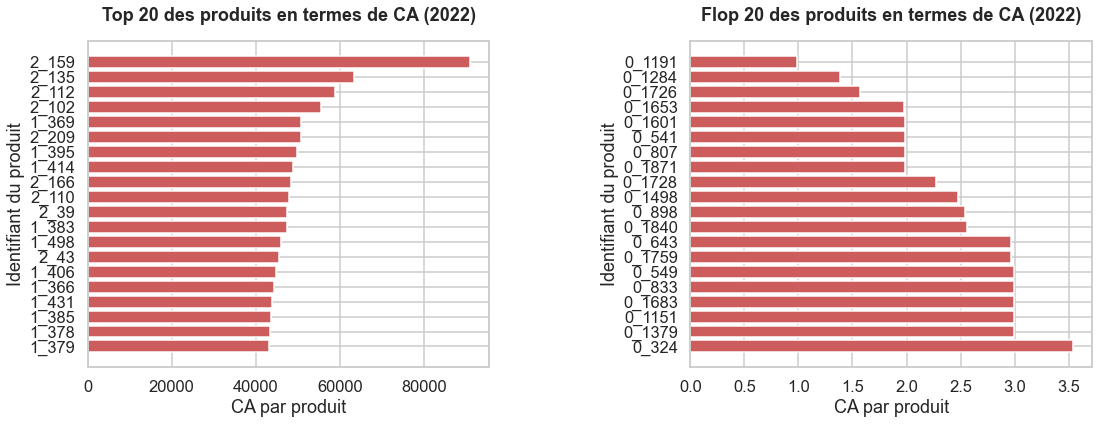

In [53]:
products = products.sort_values('turnover',ascending = False)

sns.set_context('talk')

fig, axs = plt.subplots(1,2)

fig.set_figheight(6)
fig.set_figwidth(18)

# graph du top 20 tous temps sur l'axe 1
g3 = axs[0].barh(products['id_prod'][0:20], products['turnover'][0:20], color='indianred')
axs[0].set_title(f'Top 20 des produits en termes de CA (2022)', fontsize=18, pad = 20, weight='bold')
axs[0].invert_yaxis()

# graph du top 20 tous temps sur l'axe 1
g4 = axs[1].barh(products['id_prod'][-21:-1], products['turnover'][-21:-1], color='indianred')
axs[1].set_title(f'Flop 20 des produits en termes de CA (2022)', fontsize=18, pad = 20, weight='bold')


for ax in axs[0:2].flat:
    ax.set(xlabel='CA par produit', ylabel='Identifiant du produit')

plt.subplots_adjust(wspace=0.5)

# 4. Mise en évidence des corrélations<a class="anchor" id="correlations"></a>

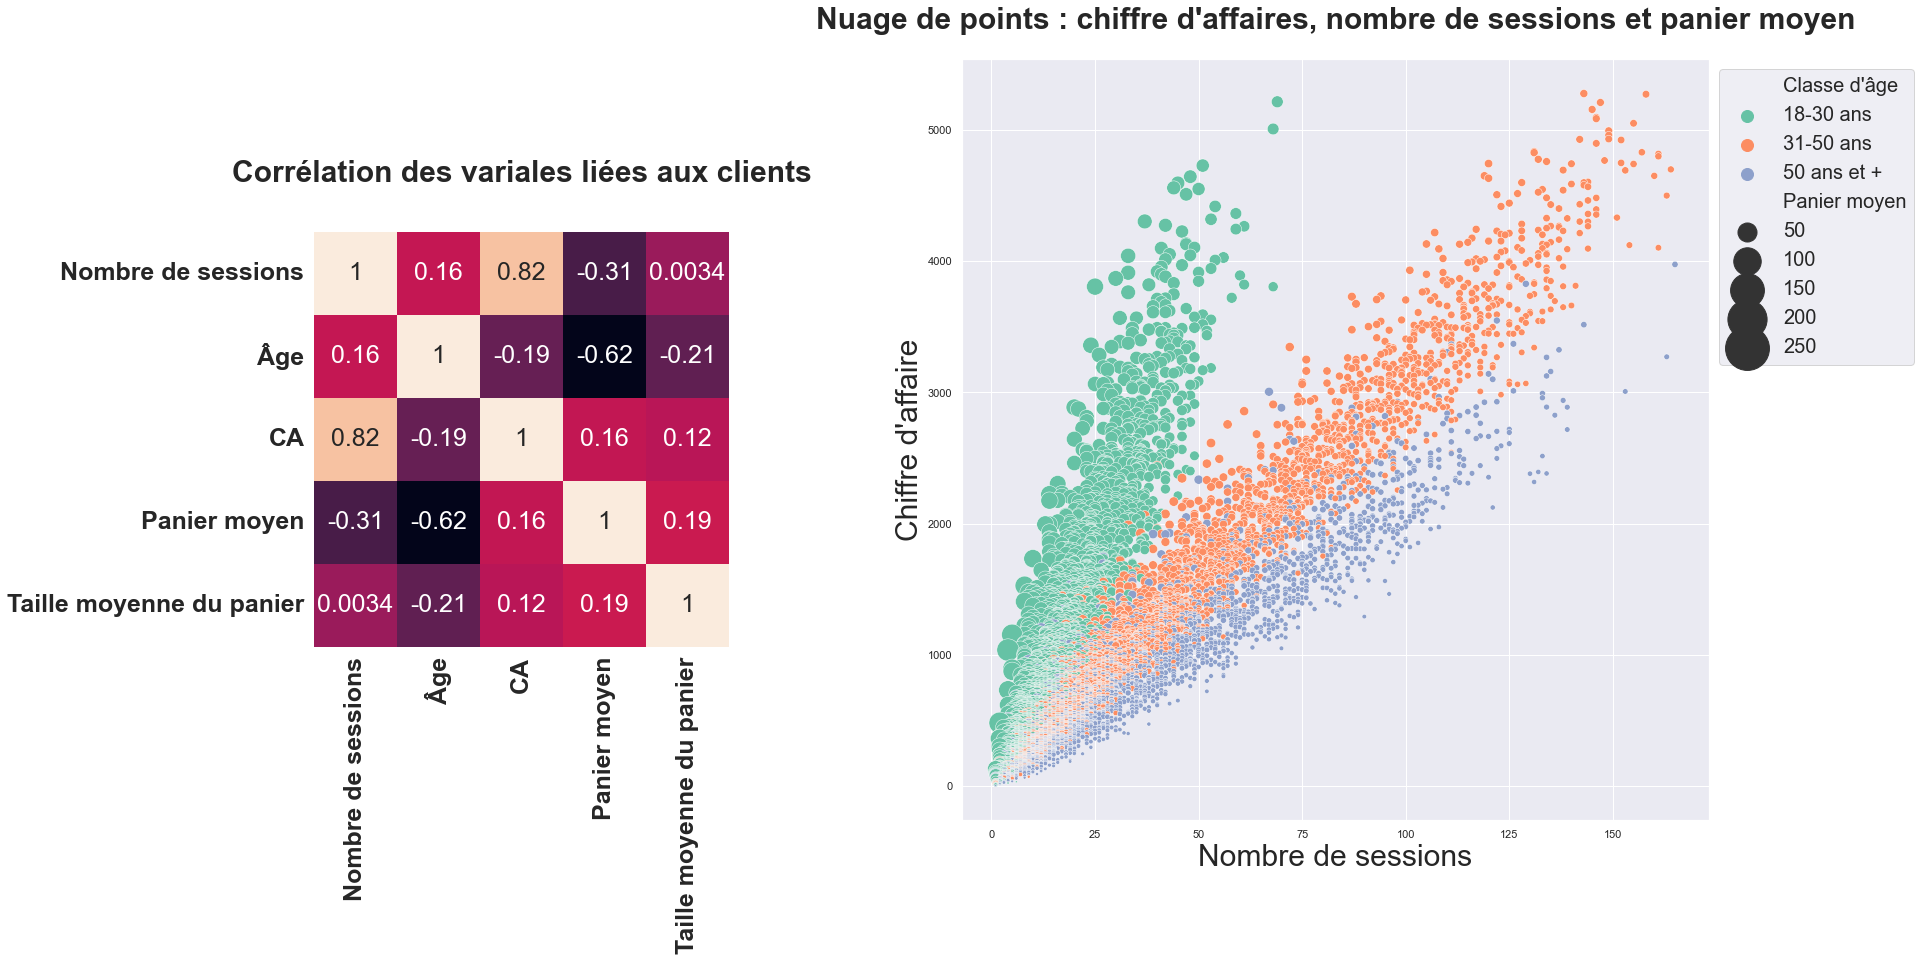

In [54]:
sns.set_context('talk')
sns.set_theme(palette='Set2')

fig, axs = plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 1.8]})

fig.set_figwidth(25)
fig.set_figheight(14)

customers_temp = customers[['client_id', 'sex', 'sessions_count','age','age_class','turnover','avg_basket','avg_bask_size']].copy()
customers_temp.rename(columns={'age_class':"Classe d'âge", 'avg_basket':'Panier moyen', 'avg_basket_size':"Taille moyenne du panier"},inplace=True)

fig1 = sns.heatmap(customers_temp.corr(), ax=axs[0], annot=True, annot_kws={"size": 25}, 
                   square = True, cbar=False)
axs[0].set_title("Corrélation des variales liées aux clients", fontsize=30, weight='bold', pad= 50)
axs[0].set_yticks([0.5,1.5,2.5,3.5,4.5],
                  ['Nombre de sessions','Âge','CA','Panier moyen',"Taille moyenne du panier"],
                  rotation=0,size=25,weight='bold')
axs[0].set_xticks([0.5,1.5,2.5,3.5,4.5],
                  ['Nombre de sessions','Âge','CA','Panier moyen',"Taille moyenne du panier"],
                  rotation=90,size=25,weight='bold')

fig2 = sns.scatterplot(x='sessions_count',
                                y='turnover',
                                data=customers_temp,
                       ax=axs[1],
                                hue = "Classe d'âge", 
                                hue_order=order_age, 
                                size='Panier moyen',
                     cmap='Set1',sizes=(1,500))

axs[1].set_title("Nuage de points : chiffre d'affaires, nombre de sessions et panier moyen", pad=30,fontsize=30, weight='bold')
axs[1].set_ylabel("Chiffre d'affaire",fontsize=30)
axs[1].set_xlabel("Nombre de sessions",fontsize=30)
leg2 = axs[1].legend(bbox_to_anchor=(1,1),fontsize=20, markerscale=2)

axs[1].grid('darkgrid')

plt.subplots_adjust(wspace=0.4)

## Tests statistiques

### Relation entre âge et montant total des achats

Comme nous l'avons vu plus haut, l'âge des clients ne suit une pas une distribution normale. Nous optons donc pour un test non paramétrique pour vérifier la corrélation entre l'âge et la taille moyenne du panier, en l'occurence un test de corrélation de Spearman.

In [55]:
print("Corrélation de Spearman:", scipy.stats.spearmanr(customers['age'],customers['turnover']))

Corrélation de Spearman: SpearmanrResult(correlation=-0.18509570379195867, pvalue=4.069814409715916e-67)


### Relation entre âge et la fréquence d'achat (nombre de sessions)

In [56]:
print("Corrélation de Spearman:", scipy.stats.spearmanr(customers['age'],customers['sessions_count']))

Corrélation de Spearman: SpearmanrResult(correlation=0.21234739496458024, pvalue=3.180991037736119e-88)


### Relation entre âge et taille du panier

In [57]:
print("Corrélation de Spearman:", scipy.stats.spearmanr(customers['age'],customers['avg_bask_size']))

Corrélation de Spearman: SpearmanrResult(correlation=-0.20722634464739545, pvalue=5.098966418875619e-84)


### Relations entre âge et catégories

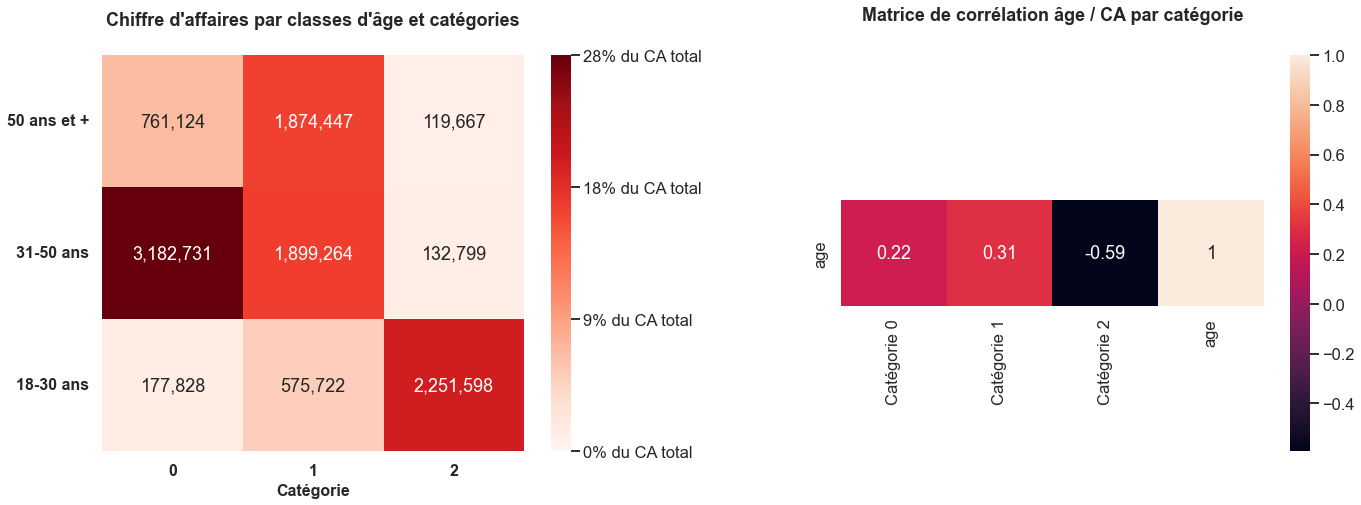

In [58]:
# préparation des données et des libellés pour le tableau de contingence du CA
heat_age_class = clients_categ.groupby('age_class').sum()
heat_age_class = heat_age_class.drop('age',axis=1)
tot_turn = transactions['price'].sum()
min_v = 0
max_v_ratio = int(heat_age_class.max().max() / tot_turn * 100)
max_3rd = int(max_v_ratio/3)
max_two_3rd = int(max_3rd*2)
max_100 = int(tot_turn*max_v_ratio/100)
max_div3 = int(tot_turn*(max_v_ratio/3)/100)
max_div2 = int(max_div3*2)


# préparation des données pour le tableau de corrélation âge / CA par catégorie
categ_age_corr = clients_categ.corr('spearman')
categ_age_corr = categ_age_corr.drop(['Catégorie 0','Catégorie 1','Catégorie 2'])

# création du graphique

sns.set_context('talk')

fig, axs = plt.subplots(1,2)

fig.set_figwidth(16)
fig.set_figheight(5)

# création d'un tableau du CA par classes d'âge / catégories
ax = sns.heatmap(heat_age_class, 
                 ax=axs[0],cmap='Reds', 
                 fmt=',.0f',annot=True, 
                 annot_kws={"size": 18},
                 vmin=min_v, 
                 vmax=max_100)
axs[0].set_title("Chiffre d'affaires par classes d'âge et catégories", fontsize=18, pad=30, weight='bold')
axs[0].set_xlabel("Catégorie", fontsize=16, weight='bold')
axs[0].set_ylabel("", fontsize=13)
axs[0].set_xticks([0.5,1.5,2.5],[0,1,2],size=16,weight='bold')
axs[0].set_yticks([0.5,1.5,2.5],order_age,rotation=0,size=16,weight='bold')
ax.invert_yaxis()

cbar = ax.collections[0].colorbar
cbar.set_ticks([min_v, 
                max_div3, 
                max_div2, 
                max_100])
cbar.set_ticklabels(['0% du CA total', 
                     f'{max_3rd}% du CA total', 
                     f'{max_two_3rd}% du CA total', 
                     f'{max_v_ratio}% du CA total'])

# création d'une matrice de corrélation âge/ catégories
ax = sns.heatmap(categ_age_corr, ax=axs[1],annot=True, annot_kws={"size": 18}, square = True)
axs[1].set_title("Matrice de corrélation âge / CA par catégorie", fontsize=18, pad=180, weight='bold')
axs[1].set_xlabel("", fontsize=13)
axs[1].set_ylabel("", fontsize=13)
ax.invert_yaxis()



plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=1.2, 
                    top=1.2, 
                    wspace=0.4, 
                    hspace=0.4)

#### Test de corrélation de Spearman pour âge / catégorie 0

In [59]:
scipy.stats.spearmanr(clients_categ['age'], clients_categ['Catégorie 0'], nan_policy='omit')

SpearmanrResult(correlation=0.2193252980456997, pvalue=3.914239081930634e-94)

#### Test de corrélation de Spearman pour âge / catégorie 1

In [60]:
scipy.stats.spearmanr(clients_categ['age'], clients_categ['Catégorie 1'], nan_policy='omit')

SpearmanrResult(correlation=0.307467581078712, pvalue=1.3225038121121874e-187)

#### Test de corrélation de Spearman pour âge / catégorie 2

In [61]:
scipy.stats.spearmanr(clients_categ['age'], clients_categ['Catégorie 2'], nan_policy='omit')

SpearmanrResult(correlation=-0.592633855822243, pvalue=0.0)

### Test de khi-deux : les variables "sexe" et "catégorie de produit" sont-elles indépendantes ?

**Hypothèse nulle: les deux variables sont indépendantes**

**Hypothèse alternative: les variables sont dépendantes**

Nous pourrions ici décider de placer le seuil de risque alpha à 0,05, mais nous verrons ce que le résultat donne. Nous pourrons comparer la p-valeur à différents seuils pour voir ce qu'il en est.

#### Calcul du khi-deux avec scipy.stats.chi2_contingency

In [62]:
# receuil des informations sur l'âge dans le dataframe customers
temp = customers[['client_id','sex']]
# merge avec le df transactions
trans_age_class = pd.merge(transactions,temp,on='client_id',how='left')
# création du tableau de contigence
cont = pd.crosstab(trans_age_class['sex'],trans_age_class['categ'])

(array([0.5, 1.5]), [Text(0, 0.5, 'Femmes'), Text(0, 1.5, 'Hommes')])

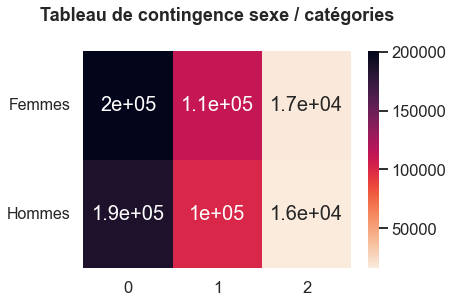

In [63]:
sns.set_context('talk')

# création d'un tableau de contingence classes d'âge / catégories

fig = plt.figure(figsize=(6,4)) 

ax = sns.heatmap(cont, cmap='rocket_r',annot=True, annot_kws={"size": 20}, yticklabels=['Femmes', 'Hommes'])
plt.title("Tableau de contingence sexe / catégories", fontsize=18, pad=30, weight='bold')
plt.xlabel("", fontsize=13)
plt.ylabel("", fontsize=13)
plt.yticks(rotation = 0, fontsize = 16)

In [64]:
# test du khi-deux entre les 2 variables qualitatives : sexe et catégorie
chi2, p_value, dof, expected = scipy.stats.chi2_contingency(cont, correction=False)
print(color.BOLD + f"Résultats :\n\n\
- khi-deux : {chi2}\n\
- degré de liberté : {dof}\n\
- p-valeur : {p_value}\n" + color.END)

if p_value <= 0.01:
    print(color.BOLD + color.RED + "Très forte présomption contre l'hypothèse nulle."+ color.END)
if 0.01 < p_value <= 0.05:
    print(color.BOLD + color.RED + "Forte présomption contre l'hypothèse nulle."+ color.END)
if 0.05 < p_value <= 0.1:
    print(color.BOLD + color.RED + "Faible présomption contre l'hypothèse nulle."+ color.END)
if 0.1 < p_value:
    print(color.BOLD + color.RED + "Pas de présomption contre l'hypothèse nulle." + color.END)

Résultats :

- khi-deux : 20.200173796862927
- degré de liberté : 2
- p-valeur : 4.1075985631484716e-05

Très forte présomption contre l'hypothèse nulle.


In [65]:
cont = np.array(cont)
n = np.sum(cont)
minDim = min(cont.shape)-1

#calculate Cramer's V 
V = np.sqrt((chi2/n) / minDim)

print(color.BOLD + color.RED + f"La valeur du V de Cramer : {V}" + color.END)

La valeur du V de Cramer : 0.0056504418660519575


Ici nous obtenons certes **une p-valeur qui indique que les variables sexe et catégorie de produit sont dépendantes**, mais le <font color ='red'>**calcul du V de Kramer semble indiquer un effet de très petite taille.**</font> Il ne semble donc pas pertinent de le prendre en compte.

# Conclusions et suggestions

- On observe <font color='red'>**pas de corrélation significative entre genre et catégorie de produits.**</font>
- Une <font color='red'>**corrélation légèrement négative entre l'âge et le montant total des achats**</font> : ce qui s'explique par le fait que les clients de  plus de 50 ans représentent environ 34% des effectifs pour seulement 25% du chiffre d'affaire.
- <font color='red'>**Pas de corrélation significative entre âge et fréquence d'achat**</font>, ceci s'expliquant par une baisse et stagnation de la fréquence d'achat au-delà des 40-49 ans
- il y a une <font color='red'>**relation négative entre âge et taille du panier moyen**</font>, même si elle n'est pas très marquée, mais <font color='red'>**surtout une relation négative entre âge et panier moyen**</font>, ce qui s'explique principalement par les catégories de livres de prédliection de chaque classe d'âge (cf. plus bas)


**Les catégories de livres**

Les observations ci-dessous pourraient amener à une étude plus ciblée des catégories de livre et de leurs références phares, mais aussi des produits les moins performants, dans le but de constituer des sotcks plus performants.
    
- les livres de la <font color='red'>**catégorie 0**</font> représentent certes <font color='red'>**38% du CA**</font>, mais près de <font color='red'>**20% de ces articles ne se sont pas vendus plus de 10 fois**</font>

    - particulièrement plébiscitée par les <font color='red'>**31-50 ans**</font> qui représentent plus des 3/4 des ventes de cette catégorie
    - avec plus d'informations sur les références produits qui affichent une moins bonne performance, il serait peut-être possible d'optimiser les stocks  
   
- les livres de la <font color='red'>**catégorie 1**</font> semblent être ceux qui génèrent <font color='red'>**un CA plus équilibré entre les tranches d'âge**</font>
     - seulement <font color='red'>**147 clients**</font> sur un total de près de 8600 n'en ont pas <font color='red'>**jamais acheté**</font>
     - cette catégorie est la seule a avoir des <font color='red'>**articles dépassant les 1200 transactions**</font>
   
- la <font color='red'>**catégorie 2**</font> est extrêmement <font color='red'>**populaire auprès des 18-30 ans**</font>
     - en raison de ses fourchettes, elle est génératrice d'un <font color='red'>**panier moyen important**</font> (environ 70€)
     - des <font color='red'>**campagnes d'acquisition de nouveaux clients**</font> en lien avec cette catégorie pourraient donc être particulièrement <font color='red'>**fructueuses en terme de ROI**</font>
     - questions stocks, il faut noter que les <font color='red'>**articles de moins de 72€**</font> se vendent particulièrement bien, représentant <font color='red'>**75% des ventes**</font> et <font color='red'>**56% du CA**</font> de cette catégorie (cf. annexe 2).
       
       
**Les "revendeurs"**

- au vu des transactions, il semblerait que certains clients soient en fait des revendeurs:
    - nombre important d'achats pour des montants élevés
    - achats répétés des mêmes références produits
- un complément d'information sur la nature des clients permettrait d'en apprendre davantage, notamment sur les éventuels revendeurs qui effectuerait des nombres plus raisonnables d'achats et pourraient être encore confondus avec les clients réguliers
- on pourrait imaginer la création d'un portail revendeurs si celui-ci n'existe pas, afin de mieux cerner leurs besoins et d'instaurer davantages de partenariats/remises


**Technique** :

Il serait intéressant d'obtenir des données sur les activités liées au site et d'approfondir la connaissance des clients, en examinant notamment :
   - la durée des sessions
   - les pages produits consultées
   - les articles ajoutés au panier lors des sessions sans achat

# Annexes<a class="anchor" id="annexes"></a>

## Annexe 1 : Transactions des revendeurs<a class="anchor" id="resellers"></a>

Etant donné que les transactions des 4 clients atypiques nommés ici revendeurs, nous pouvons obtenir un aper

Text(0.5, 1.0, 'CA des revendeurs par catégorie')

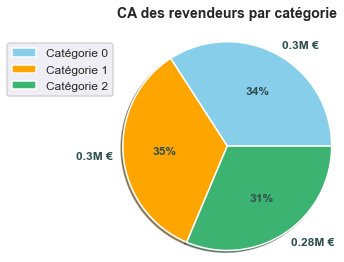

In [66]:
turn_resellers = trans_resellers['price'].sum()

turn_categ_resellers = trans_resellers.groupby('categ')['price'].sum().reset_index()
count_categ_resellers = trans_resellers.groupby('categ')['id_prod'].count().reset_index()

labels =  ['Catégorie 0','Catégorie 1','Catégorie 2']


# création des labels de chaque camembert : 
#nombre de produits pour le 1er, CA our le 2ème 
labels_count_categ = [str(count) + ' produits' for count in count_categ_resellers]
labels_turn = [str(round(ca/1000000,2)) + 'M €' for ca in turn_categ_resellers['price']]



patches, texts, autotext =  plt.pie(turn_categ_resellers['price'], 
                                       labels=labels_turn,
                                    colors=colors_prodz,
                                       shadow = True,
                                       radius = 1.2,
                                       autopct='%1.f%%',
                                       textprops={'fontsize': 12, 'weight':'bold', 'color':'darkslategrey'})

plt.legend(patches, labels, 
           bbox_to_anchor=(0,1), 
           loc="upper right", fontsize=12)

plt.title("CA des revendeurs par catégorie", fontsize=14, weight='bold', pad=20 )

Text(0, 0.5, "Nombre d'articles achetés")

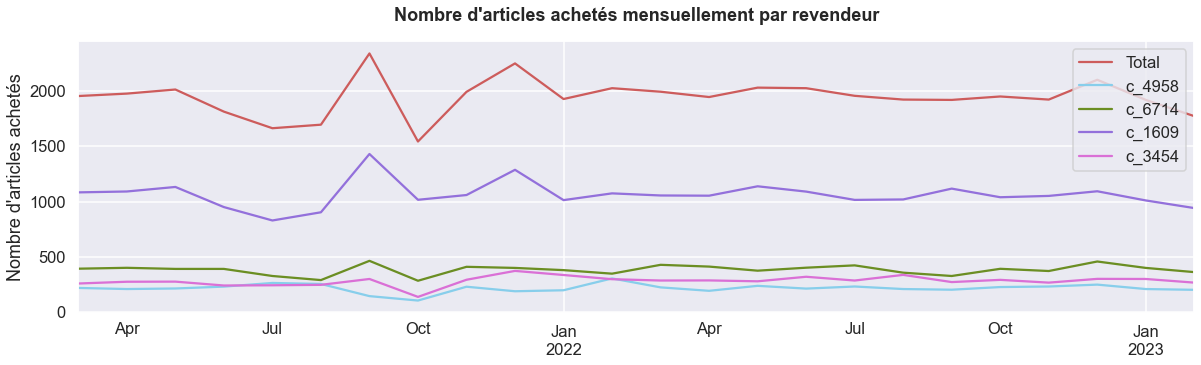

In [67]:
plt.figure(figsize=(20,5))

trans_resellers.groupby(pd.Grouper(key='date',freq='M'))['id_prod'].count().plot(label='Total', color='indianred')

colors_res = ['skyblue','olivedrab','mediumpurple','orchid']
count=0

for id in resellers['client_id'].unique():
    trans_resellers.loc[trans_resellers['client_id']==id].groupby(pd.Grouper(key='date',freq='M'))['id_prod'].count().plot(label=id, color=colors_res[count])
    count +=1

    
plt.title("Nombre d'articles achetés mensuellement par revendeur", fontsize=18, pad = 20, weight='bold')
plt.legend()

plt.xlabel('')
plt.ylabel("Nombre d'articles achetés")

## Annexe 2 : Les relation entre prix et ventes de  catégorie 2 

Il s'agit ici d'un exemple d'approfondissement des performances d'une catégorie de produit, ici la catégorie 2. Comme on peut le voir ci-dessous, il semblerait que les produits de moins de 72 euros environ soient de loins les plus performants en termes de nombres de ventes.

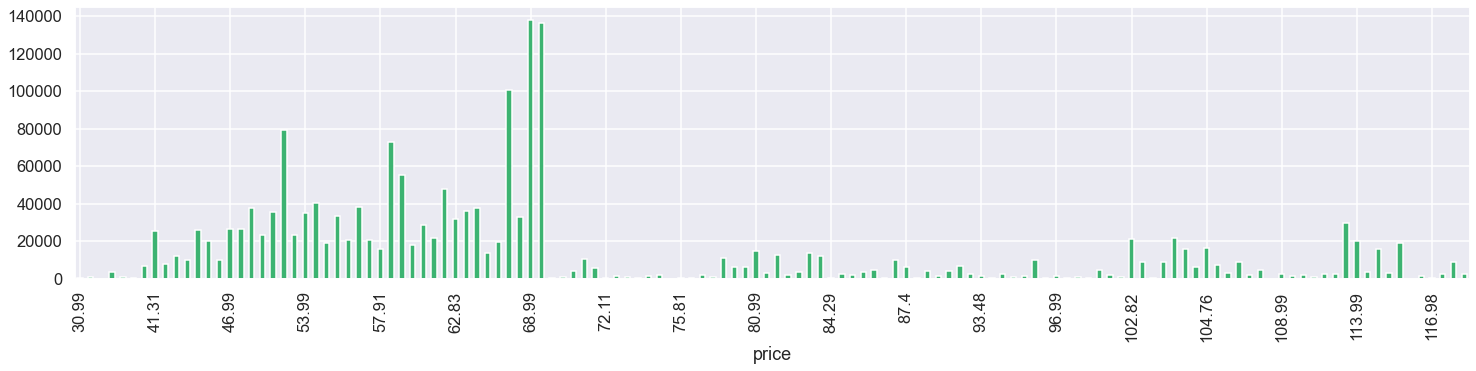

In [68]:
plt.figure(figsize=(25,5))
products.loc[(products['categ']==2)&(products['price']<120)].groupby('price')['turnover'].sum().plot(kind='bar',color=colors_prodz[2])
plt.locator_params(axis='x', nbins=20)

In [69]:
# part dans le nombre d'articles de la catégorie 2
numbercat2_less70 = round(products.loc[(products['categ']==2)&(products['price']<70)]\
                    ['id_prod'].count()/products.loc[(products['categ']==2)]['id_prod'].count() *100)
# part dans le CA de la catégorie 2 des produits de moins de 70€
turncat2_less70 = round(products.loc[(products['categ']==2)&(products['price']<70)]\
                    ['turnover'].sum()/products.loc[(products['categ']==2)]['turnover'].sum() *100)
# part dans le nombre d'articles vendus de la catégorie 2 vendus
countcat2_less70 = round(products.loc[(products['categ']==2)&(products['price']<70)]\
                    ['count_sold'].sum()/products.loc[(products['categ']==2)]['count_sold'].sum() *100)

print(color.GREEN + color.BOLD + f"On peut notamment remarquer que les produits de catégorie 2 de moins de 70€ représentent : \n\n\
- {numbercat2_less70}% des articles de la catégorie 2\n\
- {countcat2_less70}% des ventes de cette catégorie\n\
- {turncat2_less70}% du chiffre d'affaires de cette catégorie" + color.END)

On peut notamment remarquer que les produits de catégorie 2 de moins de 70€ représentent : 

- 25.0% des articles de la catégorie 2
- 74.0% des ventes de cette catégorie
- 56.0% du chiffre d'affaires de cette catégorie
